In [67]:
feature_model = torch.load(root_dir + 'FeatureNet.pkl')
print (feature_model)

AttributeError: Can't get attribute 'featureNet' on <module '__main__'>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torch.nn.init as init
import pytorch_ssim

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import pickle
import os
import json
import numpy as np
import gc
import cv2

In [67]:
epoch = 5
lr = 0.001
mom = 0.9
bs = 10

In [68]:
def odd(w):
    return list(np.arange(1, w, step=2, dtype='long'))

def even(w):
    return list(np.arange(0, w, step=2, dtype='long'))

def white(x):
    fw, tw = x.shape[1], x.shape[2]

    first = F.relu(torch.normal(mean=torch.zeros(fw, tw), std=torch.ones(fw, tw)) ) * 0.05
    second_seed = F.relu(torch.normal(mean=torch.zeros(fw//2, tw//2), std=torch.ones(fw//2, tw//2))) * 0.03
    second = torch.zeros(fw, tw)

    row_x  = torch.zeros(int(fw//2), tw)
    # row_x = torch.zeros(int(fw/2), tw)

    row_x[:, odd(tw)]  = second_seed
    row_x[:, even(tw)] = second_seed

    second[odd(fw), :]  = row_x
    second[even(fw), :] = row_x

    return second + first


In [69]:
#=============================================
#        path
#=============================================

server = False

root_dir = '/home/tk/Documents/'
if server == True:
    root_dir = '/home/guotingyou/cocktail_phase2/'


clean_dir = root_dir + 'clean/' 
# mix_dir = root_dir + 'mix/' 
# clean_label_dir = root_dir + 'clean_labels/' 
# mix_label_dir = root_dir + 'mix_labels/' 

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

# mixfolder = os.listdir(mix_dir)
# mixfolder.sort()


clean_list = []
# mix_list = []

In [70]:
class MSourceDataSet(Dataset):
    
    def __init__(self, clean_dir):
        

        # Overfitting single block
        with open(clean_dir + 'clean11.json') as f:
            clean_list.append(torch.Tensor(json.load(f)))

            
        cleanblock = torch.cat(clean_list, 0)
#         mixblock = torch.cat(mix_list, 0)
        self.spec = cleanblock
                
        
    def __len__(self):
        return self.spec.shape[0]

                
    def __getitem__(self, index): 

        spec = self.spec[index]
        return spec
    
#=============================================
#        Define Dataloader
#=============================================

trainset = MSourceDataSet(clean_dir)

trainloader = torch.utils.data.DataLoader(dataset = trainset,
                                                batch_size = bs,
                                                shuffle = True)
#=============================================
#        Define Dataloader
#=============================================

trainset = MSourceDataSet(clean_dir)

trainloader = torch.utils.data.DataLoader(dataset = trainset,
                                                batch_size = bs,
                                                shuffle = True)

In [71]:
#=============================================
#        Model
#=============================================

''' ResBlock '''
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ResBlock, self).__init__()

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.conv1 = nn.Conv2d(in_channels=channels_in, out_channels=channels_out, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels_out, out_channels=channels_out, kernel_size=(3,3), padding=1)

    def forward(self, x):
        if self.channels_out > self.channels_in:
            x1 = F.relu(self.conv1(x), inplace = True)
            x1 =        self.conv2(x1)
            x  = self.sizematch(self.channels_in, self.channels_out, x)
            return F.relu(x + x1, inplace = True)
        elif self.channels_out < self.channels_in:
            x = F.relu(self.conv1(x))
            x1 =       self.conv2(x)
            x = x + x1
            return F.relu(x, inplace = True)
        else:
            x1 = F.relu(self.conv1(x), inplace = True)
            x1 =        self.conv2(x1)
            x = x + x1
            return F.relu(x, inplace = True)

    def sizematch(self, channels_in, channels_out, x):
        zeros = torch.zeros( (x.size()[0], channels_out - channels_in, x.shape[2], x.shape[3]), dtype = torch.float32)
        return torch.cat((x, zeros), dim=1)

class ResTranspose(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ResTranspose, self).__init__()

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.deconv1 = nn.ConvTranspose2d(in_channels=channels_in, out_channels=channels_out, kernel_size=(2,2), stride=2)
        self.deconv2 = nn.Conv2d(in_channels=channels_out, out_channels=channels_out, kernel_size=(3,3), padding=1)

    def forward(self, x):
        # cin = cout
        x1 = F.relu(self.deconv1(x), inplace = True)
        x1 =        self.deconv2(x1)
        x = self.sizematch(x)
        return F.relu(x + x1, inplace = True)

    def sizematch(self, x):
        # expand
        x2 = torch.zeros(x.shape[0], self.channels_in, x.shape[2]*2, x.shape[3]*2)

        row_x  = torch.zeros(x.shape[0], self.channels_in, x.shape[2], 2*x.shape[3])
        row_x[:,:,:,odd(x.shape[3]*2)]   = x
        row_x[:,:,:,even(x.shape[3]*2)]  = x
        x2[:,:, odd(x.shape[2]*2),:] = row_x
        x2[:,:,even(x.shape[2]*2),:] = row_x

        return x2


def initialize(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)
    if isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight)





# model = ResDAE()
model = torch.load(root_dir + 'recover/SSIM-CONV/DAE_SSIM.pkl')
print (model)


/home/tk/.local/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type ResBlock. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/tk/.local/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type ResTranspose. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


ResDAE(
  (upward_net1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResBlock(
      (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upward_net2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ResBlock(
      (conv1): Con

In [72]:

#=============================================
#        Optimizer
#=============================================

#import pytorch_ssim
criterion = pytorch_ssim.SSIM()
optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, momentum = mom)

#=============================================
#        Loss Record
#=============================================

loss_record = []
# every_loss = []
# epoch_loss = []

#=============================================
#        test
#=============================================

criterion = pytorch_ssim.SSIM()

model.eval()
for epo in range(epoch):
    for i, data in enumerate(trainloader, 0):
        inputs = data
        inputs = Variable(inputs)
        top = model.upward(inputs + white(inputs))
        
        outputs = model.downward(top, shortcut = True)
        inputs = inputs.view(bs, 1, 256, 128)
        outputs = outputs.view(bs, 1, 256, 128)
        #with open ( root_dir + 'recover/L1loss_FC/recover_pic_epo_' + str(epo), 'w') as f:
        #    json.dump(outputs.tolist(), f)
        
        loss = - criterion(outputs, inputs)
        ssim_value = - loss.data.item()
        
        if i % 20 == 0:
            inn = inputs[0].view(256, 128).detach().numpy() * 255
            cv2.imwrite("/home/tk/Documents/recover/SSIM-CONV/test/" + str(epo) + "_" + str(i) + ".png", inn)
            
            out = outputs[0].view(256, 128).detach().numpy() * 255
            cv2.imwrite("/home/tk/Documents/recover/SSIM-CONV/test/" + str(epo) + "_" + str(i) + "_re.png", out)
            

AttributeError: module 'pytorch_ssim' has no attribute 'SSIM'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import pickle
import os
import json
import numpy as np



#=============================================
#        Hyperparameters
#=============================================

epoch = 2
lr = 0.001
mom = 0.9
bs = 16

#======================================
clean_dir = '/home/tk/Documents/clean/' 
clean_label_dir = '/home/tk/Documents/clean_labels/' 
#========================================

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

cleanlabelfolder = os.listdir(clean_label_dir)
cleanlabelfolder.sort()

clean_list = []
clean_label_list = []

#========================================

class featureDataSet(Dataset):
    
    def __init__(self, clean_dir, clean_label_dir):
                

        for i in cleanfolder:
            with open(clean_dir + '{}'.format(i)) as f:
                clean_list.append(torch.Tensor(json.load(f)))
                
        for i in cleanlabelfolder:
            with open(clean_label_dir + '{}'.format(i)) as f:
                clean_label_list.append(torch.Tensor(json.load(f)))
        
        cleanblock = torch.cat(clean_list, 0)
        self.spec = torch.cat([cleanblock], 0)
                
        cleanlabel = torch.cat(clean_label_list, 0)
        self.label = torch.cat([cleanlabel], 0)

        
    def __len__(self):
        return self.spec.shape[0]

                
    def __getitem__(self, index): 

        spec = self.spec[index]
        label = self.label[index]
        return spec, label

    
#=================================================    
#           Dataloader 
#=================================================
featureset = featureDataSet(clean_dir, clean_label_dir)
trainloader = torch.utils.data.DataLoader(dataset = featureset,
                                                batch_size = bs,
                                                shuffle = True)

#=================================================    
#           model 
#=================================================
class featureNet(nn.Module):
    def __init__(self):
        super(featureNet, self).__init__()
        self.fc1 = nn.Linear(256 * 128, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)

        
    def forward(self, x):
        x = x.view(-1, 256*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
    
#model = featureNet()
model = torch.load('/home/tk/Documents/FeatureNet.pkl')
print (model)

#============================================
#              optimizer
#============================================
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = mom)

#============================================
#              training
#============================================

loss_record = []
every_loss = []
epoch_loss = []


model.train()
for epoch in range(70):
    
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        every_loss.append(loss.item())
        print ('[%d, %5d] loss: %.3f' % (epoch, i, loss.item()))
        
    epoch_loss.append(np.mean(every_loss))
    every_loss = []

            
            
torch.save(model, '/home/tk/Documents/FeatureNet.pkl')


plt.figure(figsize = (20, 10))
plt.plot(loss_record)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(epoch_loss)
plt.xlabel('iterations')
plt.ylabel('epoch_loss')
plt.savefig('epoch_loss')
plt.show()

In [74]:
model = torch.load('/home/tk/Documents/FeatureNet.pkl')
print (model)

featureNet(
  (fc1): Linear(in_features=32768, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


/home/tk/.local/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type featureNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [315]:
j = open('/home/tk/Documents/mix/mix0.json').read()
a = json.loads(j)
mix = np.array(a)
print (mix.shape)

(220, 256, 128)


In [244]:
j = open('/home/tk/Documents/mix_labels/mix_label0.json').read()
a = json.loads(j)
mix_label = np.array(a)
print(mix_label.shape)

(20, 2)


In [240]:
mix_label

array([[8, 7],
       [4, 6],
       [4, 3],
       [9, 1],
       [8, 9],
       [8, 1],
       [7, 4],
       [9, 7],
       [0, 8],
       [4, 1],
       [8, 3],
       [8, 1],
       [6, 4],
       [7, 0],
       [7, 0],
       [8, 6],
       [0, 6],
       [8, 0],
       [6, 0],
       [0, 9]])

In [66]:
i = 2
index1 = (i * 11) + mix_label[i][0]
index2 = (i * 11) + mix_label[i][1]
print (index1)
print (index2)
mix_index = i * 11 + 10
print (mix_index)

NameError: name 'mix_label' is not defined

In [261]:
i = 2
index1 = (i * 11) + mix_label[i][0]
index2 = (i * 11) + mix_label[i][1]
print (index1)
print (index2)
mix_index = i * 11 + 10
print (mix_index)

26
25
32


In [263]:
mix_label[2][1]

3

In [254]:
cv2.imwrite('/home/tk/Desktop/a.png', mix[index1] * 255)
print (mix[index1])

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.02176239e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 5.19889498e-01
  5.42978210e-01 1.00000000e+00]
 ...
 [1.44138199e-03 2.03927551e-03 2.31814442e-03 ... 4.62637811e-04
  7.89675421e-04 8.49219901e-04]
 [1.07287918e-03 1.37008745e-03 1.50386281e-03 ... 1.53794700e-04
  3.07196968e-04 6.21216520e-04]
 [2.42032224e-04 1.49996426e-04 1.15045391e-04 ... 2.18073619e-03
  2.96849246e-03 4.27753112e-03]]


In [255]:
cv2.imwrite('/home/tk/Desktop/b.png', mix[index2] * 255)
print (mix[index2])

[[4.05284773e-05 3.98410597e-05 3.98345154e-05 ... 8.90631516e-05
  1.15941706e-04 1.17861566e-04]
 [1.88307903e-05 1.80878629e-05 1.81974799e-05 ... 5.65265754e-05
  9.99650600e-05 1.53485486e-04]
 [8.65778473e-07 7.13725829e-07 4.45877835e-07 ... 1.63591404e-06
  1.28119965e-05 5.98908866e-05]
 ...
 [5.29056491e-09 5.91402978e-09 6.67889369e-09 ... 3.67486706e-08
  2.50067570e-08 3.39107073e-09]
 [2.43333927e-09 4.11830265e-09 6.64502577e-09 ... 3.35489202e-07
  2.86786076e-07 2.75487550e-07]
 [8.44342994e-10 1.02317247e-09 2.83612406e-09 ... 7.25919010e-07
  3.56982595e-07 8.09511382e-08]]


In [270]:
print (mix[mix_index])

[[5.06613262e-05 2.42840316e-03 1.95877882e-03 ... 2.03071674e-03
  5.45274516e-03 6.77584875e-03]
 [3.33156840e-02 4.44002733e-02 4.48987597e-02 ... 1.16924211e-02
  1.33293181e-02 1.24881586e-02]
 [7.92597808e-02 2.95037199e-02 1.41161245e-02 ... 1.24883816e-02
  1.28239769e-02 1.10428574e-02]
 ...
 [1.51715146e-06 2.67569451e-06 9.76789590e-06 ... 1.14631439e-04
  1.21727369e-04 1.10448973e-04]
 [9.46525271e-06 5.23733453e-06 1.60264138e-06 ... 7.87736115e-05
  5.14321400e-05 3.06227908e-05]
 [8.51934868e-06 6.39732463e-06 5.68628732e-06 ... 4.30707022e-05
  4.04523268e-05 3.49109294e-05]]


In [290]:
c = (mix[index1] + mix[index2])
c = np.clip(c, np.min(c), 1)

In [292]:
np.max(c)

1.0

In [293]:
cv2.imwrite('/home/tk/Desktop/mix.png', c * 255)
print (mix[mix_index])

[[5.06613262e-05 2.42840316e-03 1.95877882e-03 ... 2.03071674e-03
  5.45274516e-03 6.77584875e-03]
 [3.33156840e-02 4.44002733e-02 4.48987597e-02 ... 1.16924211e-02
  1.33293181e-02 1.24881586e-02]
 [7.92597808e-02 2.95037199e-02 1.41161245e-02 ... 1.24883816e-02
  1.28239769e-02 1.10428574e-02]
 ...
 [1.51715146e-06 2.67569451e-06 9.76789590e-06 ... 1.14631439e-04
  1.21727369e-04 1.10448973e-04]
 [9.46525271e-06 5.23733453e-06 1.60264138e-06 ... 7.87736115e-05
  5.14321400e-05 3.06227908e-05]
 [8.51934868e-06 6.39732463e-06 5.68628732e-06 ... 4.30707022e-05
  4.04523268e-05 3.49109294e-05]]


In [207]:
print (mix_label[3])

[5 4]


In [209]:
3 * 11 + 5

38

In [208]:
print (mix_label[3][0])

5


In [134]:
with open('/home/tk/Documents/clean/clean0.json') as f:
    b = f.read()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [314]:
j = open('/home/tk/Documents/clean/clean0.json').read()
b = json.loads(b)
print (b)

TypeError: the JSON object must be str, bytes or bytearray, not 'list'

In [97]:
with open('/home/tk/Documents/mix_labels/mix_label0.json') as f:
    a = f.read()

In [102]:
print (len(a))

6400


In [83]:
b = [1,2,3,4,5,6]

In [96]:
z = np.zeros((10))
print (z[0])

0.0


In [106]:
root_dir = '/home/tk/Documents/'
clean_dir = root_dir + 'clean/' 

clean_list = []
clean_label_list = []
mix_list = []
mix_label_list = []
import torch

In [111]:
i = 0
c[i*2: (i+1)*2 ]

[[1], [1]]

In [107]:
c = [[1],[1],[2],[2]]

In [ ]:
class featureDataSet(Dataset):
    
    def __init__(self, c6lean_dir):

        with open(clean_dir + 'clean3.json') as f:
            clean_list.append(torch.Tensor(json.load(f)))
        
        with open(root_dir + "clean_labels/clean_label3.json") as f:
            clean_label_list.append(torch.Tensor(json.load(f)))

        with open(root_dir + 'mix/mix0.json') as f:
            mix_list.append(torch.Tensor(json.load(f)))
            
        with open(root_dir + 'mix_labels/mix_label0.json') as f:
            mix_label_list.append(torch.Tensor(json.load(f)))
            
        cleanblock = torch.cat(clean_list, 0)
        mixblock = torch.cat(mix_list, 0)
        self.spec = cleanblock
                
        
    def __len__(self):
        return self.spec.shape[0]

                
    def __getitem__(self, index): 

        spec = self.spec[index]
        return spec


In [112]:
for h in range(0, 200, 20):
    print (h)

0
20
40
60
80
100
120
140
160
180


In [229]:
length = 0.5
multiplication = 1

In [234]:
spec_name = os.listdir(root_dir + "slice_pointsec/")
if len(spec_name) == (10/length)* 10 * multiplication: 
    print ((10/length)* 10 * multiplication)
    print ("checked")
spec_name.sort()
print (spec_name[19])

200.0
checked
birdstudybook_0_9.wav


In [ ]:
spec = data_process.gen_spectrogram(root_dir + 'slice_pointcec/' + spec_name[])

In [ ]:
for j in range(0 + i, int(10/length) * 10 * multiplication + i, int(10/length) * multiplication):
    spec = data_process.gen_spectrogram(root_dir + 'slice_pointsec/' + spec_name[j])
    small_pcs.append(spec)

In [235]:
for j in range(0, 200, 20):
    print (j)

0
20
40
60
80
100
120
140
160
180


In [236]:
json.close()

AttributeError: module 'json' has no attribute 'close'

In [281]:
l = [1,2,3,4,5,6,7]
np.clip(l, min(l), 5)

array([1, 2, 3, 4, 5, 5, 5])

In [376]:
server = False

root_dir = '/home/tk/Documents/'
if server == True:
    root_dir = '/home/guotingyou/cocktail_phase2/'


clean_dir = root_dir + 'clean/' 
mix_dir = root_dir + 'mix/' 
clean_label_dir = root_dir + 'clean_labels/' 
mix_label_dir = root_dir + 'mix_labels/' 

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

mixfolder = os.listdir(mix_dir)
mixfolder.sort()


clean_list = []
mix_list = []
mix_label_list = []
feature_list = []

In [377]:
class mixDataSet(Dataset):
    
    def __init__(self, mix_dir, mix_label_dir):           
        
        with open(mix_dir + 'mix3.json') as f:
            mix_list.append(torch.Tensor(json.load(f)))
        
        with open(mix_label_dir + 'mix_label3.json') as f:
            mix_label_list.append(torch.Tensor(json.load(f)))
        
        mixblock = torch.cat(mix_list, 0)
        mixlabel = torch.cat(mix_label_list, 0)
        
        self.mix_spec = mixblock
        self.mix_label = mixlabel
                
        
    def __len__(self):
        return self.mix_spec.shape[0]

                
    def __getitem__(self, index): 

        mix_spec = self.mix_spec[index]
        mix_label = self.mix_label[index]
        return mix_spec, mix_label


class featureDataSet(Dataset):
    
    def __init__(self, clean_dir):
        

        with open(clean_dir + 'clean3.json') as f:
            feature_list.append(torch.Tensor(json.load(f)))      
        
        featureblock = torch.cat(feature_list, 0)
        self.featurespec = featureblock
                
        
    def __len__(self):
        return self.featurespec.shape[0]

                
    def __getitem__(self, index): 

        featurespec = self.featurespec[index]
        return featurespec

In [378]:
mixset = mixDataSet(mix_dir, mix_label_dir)

In [380]:
mspec, mlabel = mixset.__getitem__(0)

In [382]:
mlabel[0]

tensor(9.)

In [383]:
featureset = featureDataSet(clean_dir)

In [ ]:
featureset.__getitem__()

In [372]:
mixloader = torch.utils.data.DataLoader(dataset = MSourceDataSet(clean_dir),
                                                batch_size = bs,
                                                shuffle = False)

In [369]:
mixset = mixDataSet(mix_dir, mix_label_dir)
featureset = featureDataSet(clean_dir)

mixloader = torch.utils.data.DataLoader(dataset = MSourceDataSet(clean_dir),
                                                batch_size = bs,
                                                shuffle = False)

featureloader = torch.utils.data.DataLoader(dataset = featureset,
                                           batch_size = bs,
                                           shuffle = False)


RuntimeError: expected a non-empty list of Tensors

In [344]:
mixset.__len__()

220

In [359]:
mix_spec, mix_label = mixset.__getitem__(10)

In [360]:
mix_spec

tensor([[7.1211e-02, 9.6732e-02, 1.1441e-01,  ..., 2.1542e-03, 3.2162e-03,
         4.1116e-03],
        [6.6107e-02, 9.0755e-02, 1.0918e-01,  ..., 8.4901e-03, 5.8412e-03,
         5.1425e-03],
        [6.5641e-03, 5.3293e-03, 7.2872e-03,  ..., 4.8888e-03, 4.3776e-03,
         3.3129e-03],
        ...,
        [1.7836e-02, 2.2978e-02, 2.5137e-02,  ..., 6.1808e-05, 1.0718e-04,
         1.8373e-04],
        [1.9758e-02, 1.9567e-02, 1.5679e-02,  ..., 1.3179e-04, 2.1113e-04,
         3.0304e-04],
        [8.6527e-03, 6.5997e-03, 4.4745e-03,  ..., 1.0750e-04, 1.7081e-04,
         2.7934e-04]])

In [362]:
mix_label[0]

tensor(7.)

In [ ]:
featureset.__getitem__()

In [313]:
j = open(clean_dir + 'clean3.json').read()
b = json.loads(b)
print (b)

TypeError: the JSON object must be str, bytes or bytearray, not 'list'

In [316]:
j = open('/home/tk/Documents/clean/clean0.json').read()
a = json.loads(j)
mix = np.array(a)
print (mix.shape)

(200, 256, 128)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torch.nn.init as init
import pytorch_ssim

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import pickle
import os
import json
import numpy as npu
import gc
import cv2

In [364]:
epoch = 2
lr = 0.001
mom = 0.9
bs = 10

In [365]:
def odd(w):
    return list(np.arange(1, w, step=2, dtype='long'))

def even(w):
    return list(np.arange(0, w, step=2, dtype='long'))

def white(x):
    fw, tw = x.shape[1], x.shape[2]

    first = F.relu(torch.normal(mean=torch.zeros(fw, tw), std=torch.ones(fw, tw)) ) * 0.05
    second_seed = F.relu(torch.normal(mean=torch.zeros(fw//2, tw//2), std=torch.ones(fw//2, tw//2))) * 0.03
    second = torch.zeros(fw, tw)

    row_x  = torch.zeros(int(fw//2), tw)
    # row_x = torch.zeros(int(fw/2), tw)

    row_x[:, odd(tw)]  = second_seed
    row_x[:, even(tw)] = second_seed

    second[odd(fw), :]  = row_x
    second[even(fw), :] = row_x

    return second + first

In [9]:
server = False

root_dir = '/home/tk/Documents/'
if server == True:
    root_dir = '/home/guotingyou/cocktail_phase2/'


clean_dir = root_dir + 'clean/' 
mix_dir = root_dir + 'mix/' 
clean_label_dir = root_dir + 'clean_labels/' 
mix_label_dir = root_dir + 'mix_labels/' 

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

mixfolder = os.listdir(mix_dir)
mixfolder.sort()


clean_list = []
mix_list = []
mix_label_list = []
feature_list = []

In [367]:
class mixDataSet(Dataset):
    
    def __init__(self, mix_dir, mix_label_dir):           
        
        with open(mix_dir + 'mix3.json') as f:
            mix_list.append(torch.Tensor(json.load(f)))
        
        with open(mix_label_dir + 'mix_label3.json') as f:
            mix_label_list.append(torch.Tensor(json.load(f)))
        
        mixblock = torch.cat(mix_list, 0)
        mixlabel = torch.cat(mix_label_list, 0)
        
        self.mix_spec = mixblock
        self.mix_label = mixlabel
                
        
    def __len__(self):
        return self.mix_spec.shape[0]

                
    def __getitem__(self, index): 

        mix_spec = self.spec[index]
        mix_label = self.mix_label[index]
        return mix_spec, mix_label


class featureDataSet(Dataset):
    
    def __init__(self, clean_dir):
        

        with open(clean_dir + 'clean3.json') as f:
            feature_list.append(torch.Tensor(json.load(f)))      
        
        featureblock = torch.cat(clean_list, 0)
        self.featurespec = featureblock
                
        
    def __len__(self):
        return self.featurespec.shape[0]

                
    def __getitem__(self, index): 

        featurespec = self.featurespec[index]
        return featurespec

In [368]:
mixset = mixDataSet(mix_dir)
featureset = featureDataset(clean_dir)

mixloader = torch.utils.data.DataLoader(dataset = mixset,
                                                batch_size = bs,
                                                shuffle = False)

featureloader = torch.utils.data.DataLoader(dataset = featureset,
                                           batch_size = bs,
                                           shuffle = False)

TypeError: __init__() missing 1 required positional argument: 'mix_label_dir'

In [ ]:
'''featureNet'''
class featureNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1025*16, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)

        
    def forward(self, x):
        x = x.view(-1, 1025*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#        x = torch.sigmoid(self.fc3(x))
        
        return x

#feature_model = featureNet()
feature_model = torch.load(root_dir + 'FeatureNet.pkl')
    
'''ANet'''
class ANet(nn.Module):
    def __init__(self):
        super(ANet, self).__init__()

        self.linear7 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
        )
        self.linear6 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.linear5 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.linear4 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
        )
        self.linear2 = nn.Sequential(
            nn.Linear(256, 16),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.view(bs, 1, 256)

        a7 = self.linear7(x).view(bs, 512, 1, 1)
        a6 = self.linear6(x).view(bs, 256, 1, 1)
        a5 = self.linear5(x).view(bs, 128, 1, 1)
        a4 = self.linear4(x).view(bs, 64, 1, 1)
        a3 = self.linear3(x).view(bs, 32, 1, 1)
        a2 = self.linear2(x).view(bs, 16, 1, 1)

return a7, a6, a5, a4, a3, a2

A_model = ANet()


''' ResBlock '''
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ResBlock, self).__init__()

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.conv1 = nn.Conv2d(in_channels=channels_in, out_channels=channels_out, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels_out, out_channels=channels_out, kernel_size=(3,3), padding=1)

    def forward(self, x):
        if self.channels_out > self.channels_in:
            x1 = F.relu(self.conv1(x), inplace = True)
            x1 =        self.conv2(x1)
            x  = self.sizematch(self.channels_in, self.channels_out, x)
            return F.relu(x + x1, inplace = True)
        elif self.channels_out < self.channels_in:
            x = F.relu(self.conv1(x))
            x1 =       self.conv2(x)
            x = x + x1
            return F.relu(x, inplace = True)
        else:
            x1 = F.relu(self.conv1(x), inplace = True)
            x1 =        self.conv2(x1)
            x = x + x1
            return F.relu(x, inplace = True)

    def sizematch(self, channels_in, channels_out, x):
        zeros = torch.zeros( (x.size()[0], channels_out - channels_in, x.shape[2], x.shape[3]), dtype = torch.float32)
        return torch.cat((x, zeros), dim=1)

class ResTranspose(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ResTranspose, self).__init__()

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.deconv1 = nn.ConvTranspose2d(in_channels=channels_in, out_channels=channels_out, kernel_size=(2,2), stride=2)
        self.deconv2 = nn.Conv2d(in_channels=channels_out, out_channels=channels_out, kernel_size=(3,3), padding=1)

    def forward(self, x):
        # cin = cout
        x1 = F.relu(self.deconv1(x), inplace = True)
        x1 =        self.deconv2(x1)
        x = self.sizematch(x)
        return F.relu(x + x1, inplace = True)

    def sizematch(self, x):
        # expand
        x2 = torch.zeros(x.shape[0], self.channels_in, x.shape[2]*2, x.shape[3]*2)

        row_x  = torch.zeros(x.shape[0], self.channels_in, x.shape[2], 2*x.shape[3])
        row_x[:,:,:,odd(x.shape[3]*2)]   = x
        row_x[:,:,:,even(x.shape[3]*2)]  = x
        x2[:,:, odd(x.shape[2]*2),:] = row_x
        x2[:,:,even(x.shape[2]*2),:] = row_x

        return x2


def initialize(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)
    if isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight)



class ResDAE(nn.Module):
    def __init__(self):
        super(ResDAE, self).__init__()

        # 128x128x1

        self.upward_net1 = nn.Sequential(
            ResBlock(1, 1),
            ResBlock(1, 8),
            ResBlock(8, 8),
            nn.BatchNorm2d(8),
        )

        # 64x64x8

        self.upward_net2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(8, 8),
            ResBlock(8, 16),
            ResBlock(16, 16),
            nn.BatchNorm2d(16),
        )

        # 32x32x16

        self.upward_net3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(16, 16),
            ResBlock(16, 32),
            ResBlock(32, 32),
            nn.BatchNorm2d(32),
        )

        # 16x16x32

        self.upward_net4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(32, 32),
            ResBlock(32, 64),
            ResBlock(64, 64),
            nn.BatchNorm2d(64),
        )

        # 8x8x64

        self.upward_net5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(64, 64),
            ResBlock(64, 128),
            ResBlock(128, 128),
            nn.BatchNorm2d(128),
        )

        # 4x4x128

        self.upward_net6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(128, 128),
            ResBlock(128, 256),
            ResBlock(256, 256),
            nn.BatchNorm2d(256),
        )

        # 2x2x256

        self.upward_net7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2,2), stride=2),
            nn.ReLU(),
            ResBlock(256, 256),
            ResBlock(256, 512),
            ResBlock(512, 512),
            nn.BatchNorm2d(512),
        )

        # 1x1x512
        self.downward_net7 = nn.Sequential(
            ResBlock(512, 512),
            ResBlock(512, 256),
            ResBlock(256, 256),
            ResTranspose(256, 256),
#            nn.ConvTranspose2d(256, 256, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(256),
        )

        # 2x2x256

        self.downward_net6 = nn.Sequential(
            # 8x8x64
            ResBlock(256, 256),
            ResBlock(256, 128),
            ResBlock(128, 128),
            ResTranspose(128, 128),
#            nn.ConvTranspose2d(128, 128, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(128),
        )

        # 4x4x128
        # cat -> 4x4x256
        self.uconv5 = nn.Conv2d(256, 128, kernel_size=(3,3), padding=(1,1))
        # 4x4x128
        self.downward_net5 = nn.Sequential(
            ResBlock(128, 128),
            ResBlock(128, 64),
            ResBlock(64, 64),
            ResTranspose(64, 64),
#            nn.ConvTranspose2d(64, 64, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(64),
        )

        # 8x8x64
        # cat -> 8x8x128
        self.uconv4 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        # 8x8x64
        self.downward_net4 = nn.Sequential(
            ResBlock(64, 64),
            ResBlock(64, 32),
            ResBlock(32, 32),
            ResTranspose(32, 32),
#            nn.ConvTranspose2d(32, 32, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(32),
        )

        # 16x16x32
        # cat -> 16x16x64
        self.uconv3 = nn.Conv2d(64, 32, kernel_size=(3,3), padding=(1,1))
        # 16x16x32
        self.downward_net3 = nn.Sequential(
            ResBlock(32, 32),
            ResBlock(32, 16),
            ResBlock(16, 16),
            ResTranspose(16, 16),
#            nn.ConvTranspose2d(16, 16, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(16),
        )

        # 32x32x16
        # cat -> 32x32x32
        self.uconv2 = nn.Conv2d(32, 16, kernel_size=(3,3), padding=(1,1))
        # 32x32x16
        self.downward_net2 = nn.Sequential(
            ResBlock(16, 16),
            ResBlock(16, 8),
            ResBlock(8, 8),
            ResTranspose(8, 8),
#            nn.ConvTranspose2d(8, 8, kernel_size = (2,2), stride = 2),
            nn.BatchNorm2d(8),
        )

        # 64x64x8
        self.downward_net1 = nn.Sequential(
            ResBlock(8, 8),
            ResBlock(8, 1),
            ResBlock(1, 1),
            ResBlock(1, 1),
            nn.BatchNorm2d(1),
        )

        # 128x128x1
        
        self.apply(initialize)


    def upward(self, x, a7= True, a6= True, a5= True, a4= True, a3= True, a2= True):
        x = x.view(bs, 1, 256, 128)

        # 1x256x128
#        print ("initial", x.shape)

        x = self.upward_net1(x)
#        print ("after conv1", x.shape)


        # 8x128x64
        x = self.upward_net2(x)
        if a2 is not None: x = x * a2
        self.x2 = x
#        print ("after conv2", x.shape)

        # 16x64x32
        x = self.upward_net3(x)
        if a3 is not None: x = x * a3
        self.x3 = x
#        print ("after conv3", x.shape)

        # 32x32x16
        x = self.upward_net4(x)
        if a4 is not None: x = x * a4
        self.x4 = x
#        print ("after conv4", x.shape)

        # 64x16x8
        x = self.upward_net5(x)
        if a5 is not None: x = x * a5
        self.x5 = x
#        print ("after conv5", x.shape)

        
        # 128x8x4
        x = self.upward_net6(x)
        if a6 is not None: x = x * a6
#        print ("after conv6", x.shape)

        # 256x4x2
        x = self.upward_net7(x)
        if a7 is not None: x = x * a7
#        print ("after conv7", x.shape)

        # 512x2x1
        return x


    def downward(self, y, shortcut= True):
#        print ("begin to downward, y.shape = ", y.shape)
        # 512x2x1
        y = self.downward_net7(y)
#        print ("after down7", y.shape)

        # 256x4x2
        y = self.downward_net6(y)
#        print ("after down6", y.shape)

        # 128x8x4
        if shortcut:
            y = torch.cat((y, self.x5), 1)
            y = F.relu(self.uconv5(y))
        y = self.downward_net5(y)
#        print ("after down5", y.shape)

        # 64x16x8
        if shortcut:
            y = torch.cat((y, self.x4), 1)
            y = F.relu(self.uconv4(y))
        y = self.downward_net4(y)
#        print ("after down4", y.shape)

        # 32x32x16
        if shortcut:
            y = torch.cat((y, self.x3), 1)
            y = F.relu(self.uconv3(y))
        y = self.downward_net3(y)
#        print ("after down3", y.shape)

        # 16x64x32
        if shortcut:
            y = torch.cat((y, self.x2), 1)
            y = F.relu(self.uconv2(y))
        y = self.downward_net2(y)
#        print ("after down2", y.shape)

        # 8x128x64
        y = self.downward_net1(y)
#        print ("after down1", y.shape)
 
        # 1x256x128
        return y

# Res_model = ResDAE()
Res_model = torch.load(root_dir + 'recover/SSIM-CONV/DAE_SSIM.pkl')
# print (model)

In [ ]:
#import pytorch_ssim
criterion = pytorch_ssim.SSIM()
optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, momentum = mom)

In [ ]:
loss_record = []

In [ ]:
model.train()
for epo in range(epoch):
    for i, data in enumerate(trainloader, 0):
        inputs = data
        inputs = Variable(inputs)
        optimizer.zero_grad()
        top = model.upward(inputs + white(inputs))
        
        outputs = model.downward(top, shortcut = True)
        inputs = inputs.view(bs, 1, 256, 128)
        outputs = outputs.view(bs, 1, 256, 128)
        #with open ( root_dir + 'recover/L1loss_FC/recover_pic_epo_' + str(epo), 'w') as f:
        #    json.dump(outputs.tolist(), f)
        
        loss = - criterion(outputs, inputs)
        ssim_value = - loss.data.item()
        loss.backward()
        optimizer.step()
        
        loss_record.append(loss.item())
        plt.figure(figsize = (20, 10))
        plt.plot(loss_record)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.savefig(root_dir + 'recover/SSIM-CONV/DAE_loss.png')
        
        if i % 20 == 0:
            inn = inputs[0].view(256, 128).detach().numpy() * 255
            cv2.imwrite("/home/tk/Documents/recover/SSIM-CONV/" + str(epo) + "_" + str(i) + ".png", inn)
            
            out = outputs[0].view(256, 128).detach().numpy() * 255
            cv2.imwrite("/home/tk/Documents/recover/SSIM-CONV/" + str(epo) + "_" + str(i) + "_re.png", out)
            
            
#        every_loss.append(loss.item())
#        del inputs, data

        if i % 10 == 0:
            print ('[%d, %5d] loss: %.3f' % (epo, i, loss.item()))
#            print ('[%d, %5d] ssim: %.3f' % (epo, i, ssim_value))
   
    gc.collect()
    plt.close("all")

#    epoch_loss.append(np.mean(every_loss))
#    every_loss = []
    


#        plt.figure(figsize = (20, 10))
#        plt.plot(epoch_loss)
#        plt.xlabel('epocs')
#        plt.ylabel('epoch_loss')
#        plt.savefig(root_dir + 'DAE_epoch_loss')

    
#=============================================
#        Save Model & Loss
#=============================================

torch.save(model, root_dir + 'recover/SSIM-CONV/DAE_SSIM.pkl')

In [4]:
import torch
import torch.DataSets

ModuleNotFoundError: No module named 'torch.DataSets'

In [60]:
mix_list = []
mix_label_list = []
class mixDataSet(Dataset):
    def __init__(self, mix_dir, mix_label_dir):           
        
        with open(mix_dir + 'mix3.json') as f:
            mix_list.append(torch.Tensor(json.load(f)))
        
        with open(mix_label_dir + 'mix_label3.json') as f:
            mix_label_list.append(torch.Tensor(json.load(f)))
        
        mixblock = torch.cat(mix_list, 0)
        mixlabel = torch.cat(mix_label_list, 0)
        
        self.mix_spec = mixblock
        self.mix_label = mixlabel
        
    def __len__(self):
        return self.mix_spec.shape[0]

    def __getitem__(self, spec_index, label_index): 

        mix_spec = self.mix_spec[spec_index]
        mix_label = self.mix_label[label_index]
        return mix_spec, mix_label

In [61]:
mixset = mixDataSet(mix_dir, mix_label_dir)

In [59]:
mixset.__len__()

220

In [64]:
mixset.__getitem__(150,19)

(tensor([[1.6140e-02, 2.1353e-02, 2.5107e-02,  ..., 7.2194e-05, 7.8396e-04,
          1.9516e-03],
         [1.6113e-02, 1.1937e-02, 1.0036e-02,  ..., 1.7754e-03, 4.9727e-03,
          5.6538e-03],
         [3.4493e-03, 2.6986e-03, 3.2435e-03,  ..., 7.9845e-04, 5.0764e-04,
          4.4249e-03],
         ...,
         [3.5329e-04, 1.1214e-03, 1.1732e-03,  ..., 1.1306e-03, 1.6052e-03,
          2.1083e-03],
         [1.8440e-03, 1.2443e-03, 1.1696e-03,  ..., 9.4148e-05, 3.8796e-04,
          8.0148e-04],
         [4.7128e-04, 1.0870e-03, 9.9619e-04,  ..., 3.7828e-04, 4.8897e-04,
          5.0152e-04]]), tensor([5., 1.]))

In [65]:
jh = open('/home/tk/Documents/mix/mix3.json').read()
a = json.loads(jh)

In [37]:
jh = open('/home/tk/Documents/mix_labels/mix_label3.json').read()
b = json.loads(jh)

In [38]:
a = np.array(a)
b = np.array(b)

In [39]:
a.shape

(220, 256, 128)

In [40]:
b.shape

(20, 2)

In [30]:
b = np.array(b)
b.shape

(200, 10)

In [35]:
b[]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
import numpy as np
a = np.array(a)

In [26]:
a.shape

(200, 256, 128)

In [27]:
a[140]

array([[7.11784085e-02, 9.67255617e-02, 1.14405421e-01, ...,
        1.95828029e-03, 3.05511659e-03, 3.08460772e-03],
       [6.55386052e-02, 9.01635017e-02, 1.08644251e-01, ...,
        1.46356373e-03, 1.32155836e-03, 2.40828044e-03],
       [5.39315643e-03, 4.55037297e-03, 6.78500276e-03, ...,
        4.74542215e-04, 6.32826727e-04, 5.94058274e-04],
       ...,
       [1.78358895e-02, 2.29770970e-02, 2.51348601e-02, ...,
        1.87806680e-05, 1.57008755e-05, 1.07058814e-05],
       [1.97561709e-02, 1.95657170e-02, 1.56791306e-02, ...,
        1.70555500e-05, 2.31380411e-05, 2.71272849e-05],
       [8.65012047e-03, 6.59746035e-03, 4.47201857e-03, ...,
        6.55218609e-05, 4.83742268e-05, 2.87863932e-05]])

In [69]:
mixfolder = os.listdir(mix_dir)
mixfolder.sort()

In [70]:
mixfolder

['mix0.json',
 'mix1.json',
 'mix2.json',
 'mix3.json',
 'mix4.json',
 'mix5.json',
 'mix6.json',
 'mix7.json',
 'mix8.json',
 'mix9.json']

In [31]:
clean_dir = root_dir + 'clean/' 
mix_dir = root_dir + 'mix/' 
clean_label_dir = root_dir + 'clean_labels/' 
mix_label_dir = root_dir + 'mix_labels/' 

NameError: name 'root_dir' is not defined

In [2]:
a = [1.0623e-07, 1.3231e-03, 5.5651e-06, 2.8495e-02, 1.3299e-04, 5.2328e-06, 7.2000e-04, 2.8051e-05, 3.9795e-02, 9.8838e-01]

In [5]:
torch.max(a, 0)

TypeError: max() received an invalid combination of arguments - got (list, int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, Tensor out)
 * (Tensor input, int dim, bool keepdim, tuple of Tensors out)


In [8]:
a = torch.tensor([[1.0578e-02, 3.3309e-01, 5.5529e-01, 1.0909e-02, 3.8428e-02, 1.3777e-03,
         1.2060e-02, 4.5675e-02, 1.5102e-01, 5.5134e-01],
        [4.0438e-05, 2.1043e-04, 1.2589e-01, 5.1516e-03, 6.8046e-04, 9.9534e-03,
         1.8230e-03, 5.8381e-06, 2.6256e-01, 7.9211e-01],
        [1.2880e-03, 2.0016e-02, 3.5143e-02, 4.8582e-02, 1.2939e-02, 1.1453e-02,
         1.3557e-01, 3.3008e-02, 2.6488e-01, 2.6349e-01],
        [3.3836e-03, 7.3263e-02, 1.7925e-02, 2.2843e-01, 4.1886e-02, 1.5798e-02,
         2.4491e-02, 5.4132e-03, 1.6431e-01, 2.7407e-02],
        [5.5855e-02, 1.1084e-01, 1.7244e-02, 6.8025e-04, 2.2809e-02, 3.1570e-01,
         3.4346e-03, 3.9227e-01, 7.6018e-03, 1.7340e-01],
        [2.1523e-01, 7.6109e-02, 4.9581e-02, 9.8011e-04, 1.0011e-01, 2.1144e-01,
         1.9372e-02, 4.0609e-02, 1.3001e-02, 2.5672e-03],
        [7.3727e-02, 2.0658e-01, 9.7838e-02, 5.0830e-04, 4.4293e-03, 4.8621e-03,
         6.2715e-02, 4.8715e-02, 2.3443e-03, 8.7680e-04],
        [1.0301e-04, 2.3858e-03, 1.3977e-02, 6.8922e-04, 8.5931e-03, 2.2245e-04,
         9.8420e-01, 3.0137e-03, 6.7784e-02, 6.7894e-03],
        [2.2825e-03, 1.6498e-01, 2.2518e-02, 1.0465e-03, 7.4058e-03, 8.8901e-01,
         8.0338e-02, 1.3140e-01, 1.8809e-03, 3.2917e-03],
        [8.2398e-03, 5.5224e-02, 2.2561e-02, 1.9494e-04, 2.3196e-02, 3.1043e-03,
         3.8204e-01, 9.6084e-03, 1.9456e-03, 1.7574e-03],
        [1.0623e-07, 1.3231e-03, 5.5651e-06, 2.8495e-02, 1.3299e-04, 5.2328e-06,
         7.2000e-04, 2.8051e-05, 3.9795e-02, 9.8838e-01],
        [3.3474e-03, 1.8030e-03, 9.8147e-01, 8.5557e-05, 2.4013e-05, 1.0115e-02,
         8.4762e-04, 1.3052e-03, 7.6764e-03, 1.2625e-04],
        [2.0284e-03, 6.2676e-04, 1.0758e-04, 1.1942e-06, 1.7032e-05, 2.7349e-04,
         5.7749e-03, 2.9111e-01, 6.8634e-04, 1.4915e-04],
        [1.3000e-03, 2.7204e-05, 2.6371e-03, 4.6776e-04, 1.0860e-05, 8.1055e-04,
         3.0986e-04, 2.8704e-06, 9.5868e-02, 1.2196e-01],
        [8.1448e-04, 5.3910e-06, 4.3349e-05, 9.9108e-01, 2.1359e-05, 2.3141e-08,
         3.6492e-02, 8.2024e-09, 1.9351e-01, 6.2107e-05],
        [4.6230e-05, 3.4710e-02, 2.7775e-03, 1.2075e-05, 1.6022e-04, 9.7403e-01,
         1.1194e-02, 5.7854e-02, 4.9520e-06, 6.2279e-06]])


In [15]:
_, predict = torch.max(a, 1)

In [16]:
predict

tensor([2, 9, 8, 3, 7, 0, 1, 6, 5, 6, 9, 2, 7, 9, 3, 5])

In [19]:
blank = []
for i in predict:
    b = np.zeros(10)
    b[i] = 1
    blank.append(b)
    

In [14]:
b

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
print (blank)

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])]


In [22]:
labels = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [24]:
predicted = torch.tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=torch.float64)

In [25]:
labels == predicted

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'other'

In [26]:
9/16

0.5625

In [27]:
class featureDataSet(Dataset):
    def __init__(self, clean_dir, clean_label_dir):
                
        for i in cleanfolder:
            with open(clean_dir + '{}'.format(i)) as f:
                clean_list.append(torch.Tensor(json.load(f)))
                
        for i in cleanlabelfolder:
            with open(clean_label_dir + '{}'.format(i)) as f:
                clean_label_list.append(torch.Tensor(json.load(f)))
        
        cleanblock = torch.cat(clean_list, 0)
        self.spec = torch.cat([cleanblock], 0)
                
        cleanlabel = torch.cat(clean_label_list, 0)
        self.label = torch.cat([cleanlabel], 0)

        
    def __len__(self):
        return self.spec.shape[0]

                
    def __getitem__(self, index): 

        spec = self.spec[index]
        label = self.label[index]
        return spec, label

In [37]:
root_dir = '/home/tk/Documents/'
clean_dir = root_dir + 'clean/' 
mix_dir = root_dir + 'mix/' 
clean_label_dir = root_dir + 'clean_labels/' 
mix_label_dir = root_dir + 'mix_labels/' 

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

cleanlabelfolder = os.listdir(clean_label_dir)
cleanlabelfolder.sort()

clean_list = []
clean_label_list = []

In [38]:
c = featureDataSet(clean_dir, clean_label_dir)
spec, label = c.__getitem__(0)

In [40]:
print (spec, label)

tensor([[5.3232e-04, 7.7668e-04, 4.4852e-04,  ..., 1.6614e-04, 3.3519e-04,
         8.8865e-05],
        [5.9549e-03, 5.9981e-03, 7.0182e-03,  ..., 1.0586e-03, 6.6540e-04,
         1.2536e-03],
        [9.6896e-03, 1.2987e-02, 1.3435e-02,  ..., 3.0125e-04, 3.7396e-04,
         1.6316e-05],
        ...,
        [8.0521e-04, 1.4240e-03, 2.0866e-03,  ..., 5.8042e-04, 1.0991e-04,
         4.3906e-05],
        [7.1754e-04, 1.0469e-03, 1.2815e-03,  ..., 8.0580e-04, 1.0669e-03,
         1.1908e-03],
        [3.8960e-04, 6.0420e-04, 6.2849e-04,  ..., 6.2810e-04, 1.0329e-03,
         1.4202e-03]]) tensor(0.)


#### White noise

In [78]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

def white_noise(num_samples):
    mean = -10
    std = 1
    num_samples = num_samples
    samples = np.random.normal(mean, std, size = num_samples)

    return samples

#### Pink Noise

In [45]:
def voss(nrows, ncols = 16):
    
    import pandas as pd
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    
    rows = np.random.randint(nrows, size = n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    df.fillna(method = 'ffill', axis = 0, inplace = True)
    total = df.sum(axis = 1)
    
    return total.values

In [48]:
y = voss(1000, 16)

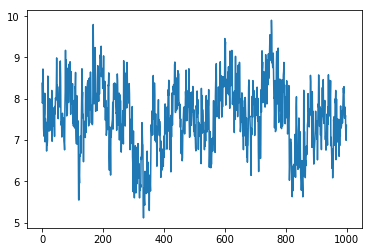

In [49]:
plt.plot(y)
plt.show()

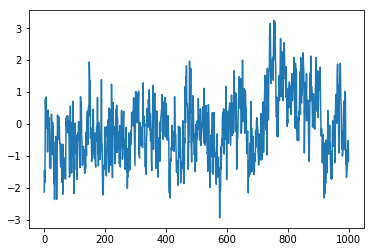

In [55]:
import colorednoise

beta = 1
samples = 1000
y = colorednoise.powerlaw_psd_gaussian(beta, samples)
plt.plot(y)
plt.show()

In [56]:
len(y)

1000

In [57]:
y = np.array(y).reshape(100, 10)
y.shape

(100, 10)

In [58]:
import cv2

In [60]:
j = open('/home/tk/Documents/clean/clean10.json').read()
a = json.loads(j)
a = np.array(a)
print(a.shape)

(200, 256, 128)


In [82]:
a[1]
cv2.imwrite('/home/tk/Desktop/original.png', a[1]*255)

True

In [100]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

def white_noise(num_samples):
    mean = 0
    std = 0.3
    num_samples = num_samples
    samples = np.random.normal(mean, std, size = num_samples)

    return samples

In [101]:
white = white_noise(256*128)
white = white.reshape(256, 128)

a_white = a[1] + white
cv2.imwrite('/home/tk/Desktop/original_white.png', a_white * 255)

True

In [80]:
a_white = a[1] + white
cv2.imwrite('/home/tk/Desktop/original_white.png', a_white * 255)

True

In [102]:
def slice_it(filename, input_path, output_path, length):
    from pydub import AudioSegment
    from pydub.utils import make_chunks
    

    # slice the file
    myaudio = AudioSegment.from_file(input_path + filename, 'wav') 
    chunks = make_chunks(myaudio, length) # Make chunks

    #Export all individual chunks as wav files
    for i, chunk in enumerate(chunks):
        chunk_name = filename[:-4] + "_{0}.wav".format(i) # select first 6 characters as file name
        print ("exporting", chunk_name)
        chunk.export(output_path + chunk_name, format="wav")

    # dump the last slice (might be an incomplete slice)
    dump_file = [] 
    chunk_list = os.listdir(output_path)
    if '.DS_Store' in chunk_list:
        chunk_list.remove('.DS_Store')

In [107]:
len(sliced_list)

5725

In [157]:
full_audio = ['birdstudybook_', 'captaincook_', 'cloudstudies_02_clayden_12_', 
              'constructivebeekeeping_',
              'discoursesbiologicalgeological_16_huxley_12_', 
              'natureguide_', 'pioneersoftheoldsouth_', 
              'pioneerworkalps_02_harper_12_', 
              'romancecommonplace_', 'travelstoriesretold_']

In [159]:
len(sliced_list)

1000

In [156]:
sliced_list[700]

'romancecommonplace_60.wav'

In [158]:
cnt = 0
sliced_list = []
for name in full_audio:
    for i in range(60, 160):
        m = name + str(i) + '.wav'
        sliced_list.append(m)
        del m
        cnt +=1
        
print (sliced_list)
print (cnt)

['birdstudybook_60.wav', 'birdstudybook_61.wav', 'birdstudybook_62.wav', 'birdstudybook_63.wav', 'birdstudybook_64.wav', 'birdstudybook_65.wav', 'birdstudybook_66.wav', 'birdstudybook_67.wav', 'birdstudybook_68.wav', 'birdstudybook_69.wav', 'birdstudybook_70.wav', 'birdstudybook_71.wav', 'birdstudybook_72.wav', 'birdstudybook_73.wav', 'birdstudybook_74.wav', 'birdstudybook_75.wav', 'birdstudybook_76.wav', 'birdstudybook_77.wav', 'birdstudybook_78.wav', 'birdstudybook_79.wav', 'birdstudybook_80.wav', 'birdstudybook_81.wav', 'birdstudybook_82.wav', 'birdstudybook_83.wav', 'birdstudybook_84.wav', 'birdstudybook_85.wav', 'birdstudybook_86.wav', 'birdstudybook_87.wav', 'birdstudybook_88.wav', 'birdstudybook_89.wav', 'birdstudybook_90.wav', 'birdstudybook_91.wav', 'birdstudybook_92.wav', 'birdstudybook_93.wav', 'birdstudybook_94.wav', 'birdstudybook_95.wav', 'birdstudybook_96.wav', 'birdstudybook_97.wav', 'birdstudybook_98.wav', 'birdstudybook_99.wav', 'birdstudybook_100.wav', 'birdstudybook

In [160]:
import os
for j in sliced_list:
    slice_it(j, '/home/tk/Documents/slice_10sec/', '/home/tk/Documents/sliced_pool/', 500)

exporting birdstudybook_60_0.wav
exporting birdstudybook_60_1.wav
exporting birdstudybook_60_2.wav
exporting birdstudybook_60_3.wav
exporting birdstudybook_60_4.wav
exporting birdstudybook_60_5.wav
exporting birdstudybook_60_6.wav
exporting birdstudybook_60_7.wav
exporting birdstudybook_60_8.wav
exporting birdstudybook_60_9.wav
exporting birdstudybook_60_10.wav
exporting birdstudybook_60_11.wav
exporting birdstudybook_60_12.wav
exporting birdstudybook_60_13.wav
exporting birdstudybook_60_14.wav
exporting birdstudybook_60_15.wav
exporting birdstudybook_60_16.wav
exporting birdstudybook_60_17.wav
exporting birdstudybook_60_18.wav
exporting birdstudybook_60_19.wav
exporting birdstudybook_61_0.wav
exporting birdstudybook_61_1.wav
exporting birdstudybook_61_2.wav
exporting birdstudybook_61_3.wav
exporting birdstudybook_61_4.wav
exporting birdstudybook_61_5.wav
exporting birdstudybook_61_6.wav
exporting birdstudybook_61_7.wav
exporting birdstudybook_61_8.wav
exporting birdstudybook_61_9.wav


exporting birdstudybook_78_0.wav
exporting birdstudybook_78_1.wav
exporting birdstudybook_78_2.wav
exporting birdstudybook_78_3.wav
exporting birdstudybook_78_4.wav
exporting birdstudybook_78_5.wav
exporting birdstudybook_78_6.wav
exporting birdstudybook_78_7.wav
exporting birdstudybook_78_8.wav
exporting birdstudybook_78_9.wav
exporting birdstudybook_78_10.wav
exporting birdstudybook_78_11.wav
exporting birdstudybook_78_12.wav
exporting birdstudybook_78_13.wav
exporting birdstudybook_78_14.wav
exporting birdstudybook_78_15.wav
exporting birdstudybook_78_16.wav
exporting birdstudybook_78_17.wav
exporting birdstudybook_78_18.wav
exporting birdstudybook_78_19.wav
exporting birdstudybook_79_0.wav
exporting birdstudybook_79_1.wav
exporting birdstudybook_79_2.wav
exporting birdstudybook_79_3.wav
exporting birdstudybook_79_4.wav
exporting birdstudybook_79_5.wav
exporting birdstudybook_79_6.wav
exporting birdstudybook_79_7.wav
exporting birdstudybook_79_8.wav
exporting birdstudybook_79_9.wav


exporting birdstudybook_94_7.wav
exporting birdstudybook_94_8.wav
exporting birdstudybook_94_9.wav
exporting birdstudybook_94_10.wav
exporting birdstudybook_94_11.wav
exporting birdstudybook_94_12.wav
exporting birdstudybook_94_13.wav
exporting birdstudybook_94_14.wav
exporting birdstudybook_94_15.wav
exporting birdstudybook_94_16.wav
exporting birdstudybook_94_17.wav
exporting birdstudybook_94_18.wav
exporting birdstudybook_94_19.wav
exporting birdstudybook_95_0.wav
exporting birdstudybook_95_1.wav
exporting birdstudybook_95_2.wav
exporting birdstudybook_95_3.wav
exporting birdstudybook_95_4.wav
exporting birdstudybook_95_5.wav
exporting birdstudybook_95_6.wav
exporting birdstudybook_95_7.wav
exporting birdstudybook_95_8.wav
exporting birdstudybook_95_9.wav
exporting birdstudybook_95_10.wav
exporting birdstudybook_95_11.wav
exporting birdstudybook_95_12.wav
exporting birdstudybook_95_13.wav
exporting birdstudybook_95_14.wav
exporting birdstudybook_95_15.wav
exporting birdstudybook_95_

exporting birdstudybook_110_4.wav
exporting birdstudybook_110_5.wav
exporting birdstudybook_110_6.wav
exporting birdstudybook_110_7.wav
exporting birdstudybook_110_8.wav
exporting birdstudybook_110_9.wav
exporting birdstudybook_110_10.wav
exporting birdstudybook_110_11.wav
exporting birdstudybook_110_12.wav
exporting birdstudybook_110_13.wav
exporting birdstudybook_110_14.wav
exporting birdstudybook_110_15.wav
exporting birdstudybook_110_16.wav
exporting birdstudybook_110_17.wav
exporting birdstudybook_110_18.wav
exporting birdstudybook_110_19.wav
exporting birdstudybook_111_0.wav
exporting birdstudybook_111_1.wav
exporting birdstudybook_111_2.wav
exporting birdstudybook_111_3.wav
exporting birdstudybook_111_4.wav
exporting birdstudybook_111_5.wav
exporting birdstudybook_111_6.wav
exporting birdstudybook_111_7.wav
exporting birdstudybook_111_8.wav
exporting birdstudybook_111_9.wav
exporting birdstudybook_111_10.wav
exporting birdstudybook_111_11.wav
exporting birdstudybook_111_12.wav
e

exporting birdstudybook_125_1.wav
exporting birdstudybook_125_2.wav
exporting birdstudybook_125_3.wav
exporting birdstudybook_125_4.wav
exporting birdstudybook_125_5.wav
exporting birdstudybook_125_6.wav
exporting birdstudybook_125_7.wav
exporting birdstudybook_125_8.wav
exporting birdstudybook_125_9.wav
exporting birdstudybook_125_10.wav
exporting birdstudybook_125_11.wav
exporting birdstudybook_125_12.wav
exporting birdstudybook_125_13.wav
exporting birdstudybook_125_14.wav
exporting birdstudybook_125_15.wav
exporting birdstudybook_125_16.wav
exporting birdstudybook_125_17.wav
exporting birdstudybook_125_18.wav
exporting birdstudybook_125_19.wav
exporting birdstudybook_126_0.wav
exporting birdstudybook_126_1.wav
exporting birdstudybook_126_2.wav
exporting birdstudybook_126_3.wav
exporting birdstudybook_126_4.wav
exporting birdstudybook_126_5.wav
exporting birdstudybook_126_6.wav
exporting birdstudybook_126_7.wav
exporting birdstudybook_126_8.wav
exporting birdstudybook_126_9.wav
expo

exporting birdstudybook_139_12.wav
exporting birdstudybook_139_13.wav
exporting birdstudybook_139_14.wav
exporting birdstudybook_139_15.wav
exporting birdstudybook_139_16.wav
exporting birdstudybook_139_17.wav
exporting birdstudybook_139_18.wav
exporting birdstudybook_139_19.wav
exporting birdstudybook_140_0.wav
exporting birdstudybook_140_1.wav
exporting birdstudybook_140_2.wav
exporting birdstudybook_140_3.wav
exporting birdstudybook_140_4.wav
exporting birdstudybook_140_5.wav
exporting birdstudybook_140_6.wav
exporting birdstudybook_140_7.wav
exporting birdstudybook_140_8.wav
exporting birdstudybook_140_9.wav
exporting birdstudybook_140_10.wav
exporting birdstudybook_140_11.wav
exporting birdstudybook_140_12.wav
exporting birdstudybook_140_13.wav
exporting birdstudybook_140_14.wav
exporting birdstudybook_140_15.wav
exporting birdstudybook_140_16.wav
exporting birdstudybook_140_17.wav
exporting birdstudybook_140_18.wav
exporting birdstudybook_140_19.wav
exporting birdstudybook_141_0.

exporting birdstudybook_157_19.wav
exporting birdstudybook_158_0.wav
exporting birdstudybook_158_1.wav
exporting birdstudybook_158_2.wav
exporting birdstudybook_158_3.wav
exporting birdstudybook_158_4.wav
exporting birdstudybook_158_5.wav
exporting birdstudybook_158_6.wav
exporting birdstudybook_158_7.wav
exporting birdstudybook_158_8.wav
exporting birdstudybook_158_9.wav
exporting birdstudybook_158_10.wav
exporting birdstudybook_158_11.wav
exporting birdstudybook_158_12.wav
exporting birdstudybook_158_13.wav
exporting birdstudybook_158_14.wav
exporting birdstudybook_158_15.wav
exporting birdstudybook_158_16.wav
exporting birdstudybook_158_17.wav
exporting birdstudybook_158_18.wav
exporting birdstudybook_158_19.wav
exporting birdstudybook_159_0.wav
exporting birdstudybook_159_1.wav
exporting birdstudybook_159_2.wav
exporting birdstudybook_159_3.wav
exporting birdstudybook_159_4.wav
exporting birdstudybook_159_5.wav
exporting birdstudybook_159_6.wav
exporting birdstudybook_159_7.wav
exp

exporting captaincook_82_7.wav
exporting captaincook_82_8.wav
exporting captaincook_82_9.wav
exporting captaincook_82_10.wav
exporting captaincook_82_11.wav
exporting captaincook_82_12.wav
exporting captaincook_82_13.wav
exporting captaincook_82_14.wav
exporting captaincook_82_15.wav
exporting captaincook_82_16.wav
exporting captaincook_82_17.wav
exporting captaincook_82_18.wav
exporting captaincook_82_19.wav
exporting captaincook_83_0.wav
exporting captaincook_83_1.wav
exporting captaincook_83_2.wav
exporting captaincook_83_3.wav
exporting captaincook_83_4.wav
exporting captaincook_83_5.wav
exporting captaincook_83_6.wav
exporting captaincook_83_7.wav
exporting captaincook_83_8.wav
exporting captaincook_83_9.wav
exporting captaincook_83_10.wav
exporting captaincook_83_11.wav
exporting captaincook_83_12.wav
exporting captaincook_83_13.wav
exporting captaincook_83_14.wav
exporting captaincook_83_15.wav
exporting captaincook_83_16.wav
exporting captaincook_83_17.wav
exporting captaincook

exporting captaincook_95_14.wav
exporting captaincook_95_15.wav
exporting captaincook_95_16.wav
exporting captaincook_95_17.wav
exporting captaincook_95_18.wav
exporting captaincook_95_19.wav
exporting captaincook_96_0.wav
exporting captaincook_96_1.wav
exporting captaincook_96_2.wav
exporting captaincook_96_3.wav
exporting captaincook_96_4.wav
exporting captaincook_96_5.wav
exporting captaincook_96_6.wav
exporting captaincook_96_7.wav
exporting captaincook_96_8.wav
exporting captaincook_96_9.wav
exporting captaincook_96_10.wav
exporting captaincook_96_11.wav
exporting captaincook_96_12.wav
exporting captaincook_96_13.wav
exporting captaincook_96_14.wav
exporting captaincook_96_15.wav
exporting captaincook_96_16.wav
exporting captaincook_96_17.wav
exporting captaincook_96_18.wav
exporting captaincook_96_19.wav
exporting captaincook_97_0.wav
exporting captaincook_97_1.wav
exporting captaincook_97_2.wav
exporting captaincook_97_3.wav
exporting captaincook_97_4.wav
exporting captaincook_9

exporting captaincook_109_0.wav
exporting captaincook_109_1.wav
exporting captaincook_109_2.wav
exporting captaincook_109_3.wav
exporting captaincook_109_4.wav
exporting captaincook_109_5.wav
exporting captaincook_109_6.wav
exporting captaincook_109_7.wav
exporting captaincook_109_8.wav
exporting captaincook_109_9.wav
exporting captaincook_109_10.wav
exporting captaincook_109_11.wav
exporting captaincook_109_12.wav
exporting captaincook_109_13.wav
exporting captaincook_109_14.wav
exporting captaincook_109_15.wav
exporting captaincook_109_16.wav
exporting captaincook_109_17.wav
exporting captaincook_109_18.wav
exporting captaincook_109_19.wav
exporting captaincook_110_0.wav
exporting captaincook_110_1.wav
exporting captaincook_110_2.wav
exporting captaincook_110_3.wav
exporting captaincook_110_4.wav
exporting captaincook_110_5.wav
exporting captaincook_110_6.wav
exporting captaincook_110_7.wav
exporting captaincook_110_8.wav
exporting captaincook_110_9.wav
exporting captaincook_110_10.w

exporting captaincook_122_6.wav
exporting captaincook_122_7.wav
exporting captaincook_122_8.wav
exporting captaincook_122_9.wav
exporting captaincook_122_10.wav
exporting captaincook_122_11.wav
exporting captaincook_122_12.wav
exporting captaincook_122_13.wav
exporting captaincook_122_14.wav
exporting captaincook_122_15.wav
exporting captaincook_122_16.wav
exporting captaincook_122_17.wav
exporting captaincook_122_18.wav
exporting captaincook_122_19.wav
exporting captaincook_123_0.wav
exporting captaincook_123_1.wav
exporting captaincook_123_2.wav
exporting captaincook_123_3.wav
exporting captaincook_123_4.wav
exporting captaincook_123_5.wav
exporting captaincook_123_6.wav
exporting captaincook_123_7.wav
exporting captaincook_123_8.wav
exporting captaincook_123_9.wav
exporting captaincook_123_10.wav
exporting captaincook_123_11.wav
exporting captaincook_123_12.wav
exporting captaincook_123_13.wav
exporting captaincook_123_14.wav
exporting captaincook_123_15.wav
exporting captaincook_12

exporting captaincook_143_9.wav
exporting captaincook_143_10.wav
exporting captaincook_143_11.wav
exporting captaincook_143_12.wav
exporting captaincook_143_13.wav
exporting captaincook_143_14.wav
exporting captaincook_143_15.wav
exporting captaincook_143_16.wav
exporting captaincook_143_17.wav
exporting captaincook_143_18.wav
exporting captaincook_143_19.wav
exporting captaincook_144_0.wav
exporting captaincook_144_1.wav
exporting captaincook_144_2.wav
exporting captaincook_144_3.wav
exporting captaincook_144_4.wav
exporting captaincook_144_5.wav
exporting captaincook_144_6.wav
exporting captaincook_144_7.wav
exporting captaincook_144_8.wav
exporting captaincook_144_9.wav
exporting captaincook_144_10.wav
exporting captaincook_144_11.wav
exporting captaincook_144_12.wav
exporting captaincook_144_13.wav
exporting captaincook_144_14.wav
exporting captaincook_144_15.wav
exporting captaincook_144_16.wav
exporting captaincook_144_17.wav
exporting captaincook_144_18.wav
exporting captaincook

exporting cloudstudies_02_clayden_12_62_13.wav
exporting cloudstudies_02_clayden_12_62_14.wav
exporting cloudstudies_02_clayden_12_62_15.wav
exporting cloudstudies_02_clayden_12_62_16.wav
exporting cloudstudies_02_clayden_12_62_17.wav
exporting cloudstudies_02_clayden_12_62_18.wav
exporting cloudstudies_02_clayden_12_62_19.wav
exporting cloudstudies_02_clayden_12_63_0.wav
exporting cloudstudies_02_clayden_12_63_1.wav
exporting cloudstudies_02_clayden_12_63_2.wav
exporting cloudstudies_02_clayden_12_63_3.wav
exporting cloudstudies_02_clayden_12_63_4.wav
exporting cloudstudies_02_clayden_12_63_5.wav
exporting cloudstudies_02_clayden_12_63_6.wav
exporting cloudstudies_02_clayden_12_63_7.wav
exporting cloudstudies_02_clayden_12_63_8.wav
exporting cloudstudies_02_clayden_12_63_9.wav
exporting cloudstudies_02_clayden_12_63_10.wav
exporting cloudstudies_02_clayden_12_63_11.wav
exporting cloudstudies_02_clayden_12_63_12.wav
exporting cloudstudies_02_clayden_12_63_13.wav
exporting cloudstudies_

exporting cloudstudies_02_clayden_12_72_9.wav
exporting cloudstudies_02_clayden_12_72_10.wav
exporting cloudstudies_02_clayden_12_72_11.wav
exporting cloudstudies_02_clayden_12_72_12.wav
exporting cloudstudies_02_clayden_12_72_13.wav
exporting cloudstudies_02_clayden_12_72_14.wav
exporting cloudstudies_02_clayden_12_72_15.wav
exporting cloudstudies_02_clayden_12_72_16.wav
exporting cloudstudies_02_clayden_12_72_17.wav
exporting cloudstudies_02_clayden_12_72_18.wav
exporting cloudstudies_02_clayden_12_72_19.wav
exporting cloudstudies_02_clayden_12_73_0.wav
exporting cloudstudies_02_clayden_12_73_1.wav
exporting cloudstudies_02_clayden_12_73_2.wav
exporting cloudstudies_02_clayden_12_73_3.wav
exporting cloudstudies_02_clayden_12_73_4.wav
exporting cloudstudies_02_clayden_12_73_5.wav
exporting cloudstudies_02_clayden_12_73_6.wav
exporting cloudstudies_02_clayden_12_73_7.wav
exporting cloudstudies_02_clayden_12_73_8.wav
exporting cloudstudies_02_clayden_12_73_9.wav
exporting cloudstudies_0

exporting cloudstudies_02_clayden_12_90_16.wav
exporting cloudstudies_02_clayden_12_90_17.wav
exporting cloudstudies_02_clayden_12_90_18.wav
exporting cloudstudies_02_clayden_12_90_19.wav
exporting cloudstudies_02_clayden_12_91_0.wav
exporting cloudstudies_02_clayden_12_91_1.wav
exporting cloudstudies_02_clayden_12_91_2.wav
exporting cloudstudies_02_clayden_12_91_3.wav
exporting cloudstudies_02_clayden_12_91_4.wav
exporting cloudstudies_02_clayden_12_91_5.wav
exporting cloudstudies_02_clayden_12_91_6.wav
exporting cloudstudies_02_clayden_12_91_7.wav
exporting cloudstudies_02_clayden_12_91_8.wav
exporting cloudstudies_02_clayden_12_91_9.wav
exporting cloudstudies_02_clayden_12_91_10.wav
exporting cloudstudies_02_clayden_12_91_11.wav
exporting cloudstudies_02_clayden_12_91_12.wav
exporting cloudstudies_02_clayden_12_91_13.wav
exporting cloudstudies_02_clayden_12_91_14.wav
exporting cloudstudies_02_clayden_12_91_15.wav
exporting cloudstudies_02_clayden_12_91_16.wav
exporting cloudstudies_

exporting cloudstudies_02_clayden_12_104_4.wav
exporting cloudstudies_02_clayden_12_104_5.wav
exporting cloudstudies_02_clayden_12_104_6.wav
exporting cloudstudies_02_clayden_12_104_7.wav
exporting cloudstudies_02_clayden_12_104_8.wav
exporting cloudstudies_02_clayden_12_104_9.wav
exporting cloudstudies_02_clayden_12_104_10.wav
exporting cloudstudies_02_clayden_12_104_11.wav
exporting cloudstudies_02_clayden_12_104_12.wav
exporting cloudstudies_02_clayden_12_104_13.wav
exporting cloudstudies_02_clayden_12_104_14.wav
exporting cloudstudies_02_clayden_12_104_15.wav
exporting cloudstudies_02_clayden_12_104_16.wav
exporting cloudstudies_02_clayden_12_104_17.wav
exporting cloudstudies_02_clayden_12_104_18.wav
exporting cloudstudies_02_clayden_12_104_19.wav
exporting cloudstudies_02_clayden_12_105_0.wav
exporting cloudstudies_02_clayden_12_105_1.wav
exporting cloudstudies_02_clayden_12_105_2.wav
exporting cloudstudies_02_clayden_12_105_3.wav
exporting cloudstudies_02_clayden_12_105_4.wav
exp

exporting cloudstudies_02_clayden_12_118_13.wav
exporting cloudstudies_02_clayden_12_118_14.wav
exporting cloudstudies_02_clayden_12_118_15.wav
exporting cloudstudies_02_clayden_12_118_16.wav
exporting cloudstudies_02_clayden_12_118_17.wav
exporting cloudstudies_02_clayden_12_118_18.wav
exporting cloudstudies_02_clayden_12_118_19.wav
exporting cloudstudies_02_clayden_12_119_0.wav
exporting cloudstudies_02_clayden_12_119_1.wav
exporting cloudstudies_02_clayden_12_119_2.wav
exporting cloudstudies_02_clayden_12_119_3.wav
exporting cloudstudies_02_clayden_12_119_4.wav
exporting cloudstudies_02_clayden_12_119_5.wav
exporting cloudstudies_02_clayden_12_119_6.wav
exporting cloudstudies_02_clayden_12_119_7.wav
exporting cloudstudies_02_clayden_12_119_8.wav
exporting cloudstudies_02_clayden_12_119_9.wav
exporting cloudstudies_02_clayden_12_119_10.wav
exporting cloudstudies_02_clayden_12_119_11.wav
exporting cloudstudies_02_clayden_12_119_12.wav
exporting cloudstudies_02_clayden_12_119_13.wav
ex

exporting cloudstudies_02_clayden_12_128_15.wav
exporting cloudstudies_02_clayden_12_128_16.wav
exporting cloudstudies_02_clayden_12_128_17.wav
exporting cloudstudies_02_clayden_12_128_18.wav
exporting cloudstudies_02_clayden_12_128_19.wav
exporting cloudstudies_02_clayden_12_129_0.wav
exporting cloudstudies_02_clayden_12_129_1.wav
exporting cloudstudies_02_clayden_12_129_2.wav
exporting cloudstudies_02_clayden_12_129_3.wav
exporting cloudstudies_02_clayden_12_129_4.wav
exporting cloudstudies_02_clayden_12_129_5.wav
exporting cloudstudies_02_clayden_12_129_6.wav
exporting cloudstudies_02_clayden_12_129_7.wav
exporting cloudstudies_02_clayden_12_129_8.wav
exporting cloudstudies_02_clayden_12_129_9.wav
exporting cloudstudies_02_clayden_12_129_10.wav
exporting cloudstudies_02_clayden_12_129_11.wav
exporting cloudstudies_02_clayden_12_129_12.wav
exporting cloudstudies_02_clayden_12_129_13.wav
exporting cloudstudies_02_clayden_12_129_14.wav
exporting cloudstudies_02_clayden_12_129_15.wav
ex

exporting cloudstudies_02_clayden_12_139_8.wav
exporting cloudstudies_02_clayden_12_139_9.wav
exporting cloudstudies_02_clayden_12_139_10.wav
exporting cloudstudies_02_clayden_12_139_11.wav
exporting cloudstudies_02_clayden_12_139_12.wav
exporting cloudstudies_02_clayden_12_139_13.wav
exporting cloudstudies_02_clayden_12_139_14.wav
exporting cloudstudies_02_clayden_12_139_15.wav
exporting cloudstudies_02_clayden_12_139_16.wav
exporting cloudstudies_02_clayden_12_139_17.wav
exporting cloudstudies_02_clayden_12_139_18.wav
exporting cloudstudies_02_clayden_12_139_19.wav
exporting cloudstudies_02_clayden_12_140_0.wav
exporting cloudstudies_02_clayden_12_140_1.wav
exporting cloudstudies_02_clayden_12_140_2.wav
exporting cloudstudies_02_clayden_12_140_3.wav
exporting cloudstudies_02_clayden_12_140_4.wav
exporting cloudstudies_02_clayden_12_140_5.wav
exporting cloudstudies_02_clayden_12_140_6.wav
exporting cloudstudies_02_clayden_12_140_7.wav
exporting cloudstudies_02_clayden_12_140_8.wav
exp

exporting cloudstudies_02_clayden_12_149_15.wav
exporting cloudstudies_02_clayden_12_149_16.wav
exporting cloudstudies_02_clayden_12_149_17.wav
exporting cloudstudies_02_clayden_12_149_18.wav
exporting cloudstudies_02_clayden_12_149_19.wav
exporting cloudstudies_02_clayden_12_150_0.wav
exporting cloudstudies_02_clayden_12_150_1.wav
exporting cloudstudies_02_clayden_12_150_2.wav
exporting cloudstudies_02_clayden_12_150_3.wav
exporting cloudstudies_02_clayden_12_150_4.wav
exporting cloudstudies_02_clayden_12_150_5.wav
exporting cloudstudies_02_clayden_12_150_6.wav
exporting cloudstudies_02_clayden_12_150_7.wav
exporting cloudstudies_02_clayden_12_150_8.wav
exporting cloudstudies_02_clayden_12_150_9.wav
exporting cloudstudies_02_clayden_12_150_10.wav
exporting cloudstudies_02_clayden_12_150_11.wav
exporting cloudstudies_02_clayden_12_150_12.wav
exporting cloudstudies_02_clayden_12_150_13.wav
exporting cloudstudies_02_clayden_12_150_14.wav
exporting cloudstudies_02_clayden_12_150_15.wav
ex

exporting constructivebeekeeping_60_6.wav
exporting constructivebeekeeping_60_7.wav
exporting constructivebeekeeping_60_8.wav
exporting constructivebeekeeping_60_9.wav
exporting constructivebeekeeping_60_10.wav
exporting constructivebeekeeping_60_11.wav
exporting constructivebeekeeping_60_12.wav
exporting constructivebeekeeping_60_13.wav
exporting constructivebeekeeping_60_14.wav
exporting constructivebeekeeping_60_15.wav
exporting constructivebeekeeping_60_16.wav
exporting constructivebeekeeping_60_17.wav
exporting constructivebeekeeping_60_18.wav
exporting constructivebeekeeping_60_19.wav
exporting constructivebeekeeping_61_0.wav
exporting constructivebeekeeping_61_1.wav
exporting constructivebeekeeping_61_2.wav
exporting constructivebeekeeping_61_3.wav
exporting constructivebeekeeping_61_4.wav
exporting constructivebeekeeping_61_5.wav
exporting constructivebeekeeping_61_6.wav
exporting constructivebeekeeping_61_7.wav
exporting constructivebeekeeping_61_8.wav
exporting constructivebe

exporting constructivebeekeeping_70_0.wav
exporting constructivebeekeeping_70_1.wav
exporting constructivebeekeeping_70_2.wav
exporting constructivebeekeeping_70_3.wav
exporting constructivebeekeeping_70_4.wav
exporting constructivebeekeeping_70_5.wav
exporting constructivebeekeeping_70_6.wav
exporting constructivebeekeeping_70_7.wav
exporting constructivebeekeeping_70_8.wav
exporting constructivebeekeeping_70_9.wav
exporting constructivebeekeeping_70_10.wav
exporting constructivebeekeeping_70_11.wav
exporting constructivebeekeeping_70_12.wav
exporting constructivebeekeeping_70_13.wav
exporting constructivebeekeeping_70_14.wav
exporting constructivebeekeeping_70_15.wav
exporting constructivebeekeeping_70_16.wav
exporting constructivebeekeeping_70_17.wav
exporting constructivebeekeeping_70_18.wav
exporting constructivebeekeeping_70_19.wav
exporting constructivebeekeeping_71_0.wav
exporting constructivebeekeeping_71_1.wav
exporting constructivebeekeeping_71_2.wav
exporting constructivebe

exporting constructivebeekeeping_89_0.wav
exporting constructivebeekeeping_89_1.wav
exporting constructivebeekeeping_89_2.wav
exporting constructivebeekeeping_89_3.wav
exporting constructivebeekeeping_89_4.wav
exporting constructivebeekeeping_89_5.wav
exporting constructivebeekeeping_89_6.wav
exporting constructivebeekeeping_89_7.wav
exporting constructivebeekeeping_89_8.wav
exporting constructivebeekeeping_89_9.wav
exporting constructivebeekeeping_89_10.wav
exporting constructivebeekeeping_89_11.wav
exporting constructivebeekeeping_89_12.wav
exporting constructivebeekeeping_89_13.wav
exporting constructivebeekeeping_89_14.wav
exporting constructivebeekeeping_89_15.wav
exporting constructivebeekeeping_89_16.wav
exporting constructivebeekeeping_89_17.wav
exporting constructivebeekeeping_89_18.wav
exporting constructivebeekeeping_89_19.wav
exporting constructivebeekeeping_90_0.wav
exporting constructivebeekeeping_90_1.wav
exporting constructivebeekeeping_90_2.wav
exporting constructivebe

exporting constructivebeekeeping_99_0.wav
exporting constructivebeekeeping_99_1.wav
exporting constructivebeekeeping_99_2.wav
exporting constructivebeekeeping_99_3.wav
exporting constructivebeekeeping_99_4.wav
exporting constructivebeekeeping_99_5.wav
exporting constructivebeekeeping_99_6.wav
exporting constructivebeekeeping_99_7.wav
exporting constructivebeekeeping_99_8.wav
exporting constructivebeekeeping_99_9.wav
exporting constructivebeekeeping_99_10.wav
exporting constructivebeekeeping_99_11.wav
exporting constructivebeekeeping_99_12.wav
exporting constructivebeekeeping_99_13.wav
exporting constructivebeekeeping_99_14.wav
exporting constructivebeekeeping_99_15.wav
exporting constructivebeekeeping_99_16.wav
exporting constructivebeekeeping_99_17.wav
exporting constructivebeekeeping_99_18.wav
exporting constructivebeekeeping_99_19.wav
exporting constructivebeekeeping_100_0.wav
exporting constructivebeekeeping_100_1.wav
exporting constructivebeekeeping_100_2.wav
exporting constructiv

exporting constructivebeekeeping_109_0.wav
exporting constructivebeekeeping_109_1.wav
exporting constructivebeekeeping_109_2.wav
exporting constructivebeekeeping_109_3.wav
exporting constructivebeekeeping_109_4.wav
exporting constructivebeekeeping_109_5.wav
exporting constructivebeekeeping_109_6.wav
exporting constructivebeekeeping_109_7.wav
exporting constructivebeekeeping_109_8.wav
exporting constructivebeekeeping_109_9.wav
exporting constructivebeekeeping_109_10.wav
exporting constructivebeekeeping_109_11.wav
exporting constructivebeekeeping_109_12.wav
exporting constructivebeekeeping_109_13.wav
exporting constructivebeekeeping_109_14.wav
exporting constructivebeekeeping_109_15.wav
exporting constructivebeekeeping_109_16.wav
exporting constructivebeekeeping_109_17.wav
exporting constructivebeekeeping_109_18.wav
exporting constructivebeekeeping_109_19.wav
exporting constructivebeekeeping_110_0.wav
exporting constructivebeekeeping_110_1.wav
exporting constructivebeekeeping_110_2.wav
e

exporting constructivebeekeeping_120_0.wav
exporting constructivebeekeeping_120_1.wav
exporting constructivebeekeeping_120_2.wav
exporting constructivebeekeeping_120_3.wav
exporting constructivebeekeeping_120_4.wav
exporting constructivebeekeeping_120_5.wav
exporting constructivebeekeeping_120_6.wav
exporting constructivebeekeeping_120_7.wav
exporting constructivebeekeeping_120_8.wav
exporting constructivebeekeeping_120_9.wav
exporting constructivebeekeeping_120_10.wav
exporting constructivebeekeeping_120_11.wav
exporting constructivebeekeeping_120_12.wav
exporting constructivebeekeeping_120_13.wav
exporting constructivebeekeeping_120_14.wav
exporting constructivebeekeeping_120_15.wav
exporting constructivebeekeeping_120_16.wav
exporting constructivebeekeeping_120_17.wav
exporting constructivebeekeeping_120_18.wav
exporting constructivebeekeeping_120_19.wav
exporting constructivebeekeeping_121_0.wav
exporting constructivebeekeeping_121_1.wav
exporting constructivebeekeeping_121_2.wav
e

exporting constructivebeekeeping_131_0.wav
exporting constructivebeekeeping_131_1.wav
exporting constructivebeekeeping_131_2.wav
exporting constructivebeekeeping_131_3.wav
exporting constructivebeekeeping_131_4.wav
exporting constructivebeekeeping_131_5.wav
exporting constructivebeekeeping_131_6.wav
exporting constructivebeekeeping_131_7.wav
exporting constructivebeekeeping_131_8.wav
exporting constructivebeekeeping_131_9.wav
exporting constructivebeekeeping_131_10.wav
exporting constructivebeekeeping_131_11.wav
exporting constructivebeekeeping_131_12.wav
exporting constructivebeekeeping_131_13.wav
exporting constructivebeekeeping_131_14.wav
exporting constructivebeekeeping_131_15.wav
exporting constructivebeekeeping_131_16.wav
exporting constructivebeekeeping_131_17.wav
exporting constructivebeekeeping_131_18.wav
exporting constructivebeekeeping_131_19.wav
exporting constructivebeekeeping_132_0.wav
exporting constructivebeekeeping_132_1.wav
exporting constructivebeekeeping_132_2.wav
e

exporting constructivebeekeeping_140_11.wav
exporting constructivebeekeeping_140_12.wav
exporting constructivebeekeeping_140_13.wav
exporting constructivebeekeeping_140_14.wav
exporting constructivebeekeeping_140_15.wav
exporting constructivebeekeeping_140_16.wav
exporting constructivebeekeeping_140_17.wav
exporting constructivebeekeeping_140_18.wav
exporting constructivebeekeeping_140_19.wav
exporting constructivebeekeeping_141_0.wav
exporting constructivebeekeeping_141_1.wav
exporting constructivebeekeeping_141_2.wav
exporting constructivebeekeeping_141_3.wav
exporting constructivebeekeeping_141_4.wav
exporting constructivebeekeeping_141_5.wav
exporting constructivebeekeeping_141_6.wav
exporting constructivebeekeeping_141_7.wav
exporting constructivebeekeeping_141_8.wav
exporting constructivebeekeeping_141_9.wav
exporting constructivebeekeeping_141_10.wav
exporting constructivebeekeeping_141_11.wav
exporting constructivebeekeeping_141_12.wav
exporting constructivebeekeeping_141_13.wa

exporting constructivebeekeeping_155_0.wav
exporting constructivebeekeeping_155_1.wav
exporting constructivebeekeeping_155_2.wav
exporting constructivebeekeeping_155_3.wav
exporting constructivebeekeeping_155_4.wav
exporting constructivebeekeeping_155_5.wav
exporting constructivebeekeeping_155_6.wav
exporting constructivebeekeeping_155_7.wav
exporting constructivebeekeeping_155_8.wav
exporting constructivebeekeeping_155_9.wav
exporting constructivebeekeeping_155_10.wav
exporting constructivebeekeeping_155_11.wav
exporting constructivebeekeeping_155_12.wav
exporting constructivebeekeeping_155_13.wav
exporting constructivebeekeeping_155_14.wav
exporting constructivebeekeeping_155_15.wav
exporting constructivebeekeeping_155_16.wav
exporting constructivebeekeeping_155_17.wav
exporting constructivebeekeeping_155_18.wav
exporting constructivebeekeeping_155_19.wav
exporting constructivebeekeeping_156_0.wav
exporting constructivebeekeeping_156_1.wav
exporting constructivebeekeeping_156_2.wav
e

exporting discoursesbiologicalgeological_16_huxley_12_68_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_68_14.wav
exporting discoursesbiologicalgeological_16_huxley

exporting discoursesbiologicalgeological_16_huxley_12_76_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_76_14.wav
exporting discoursesbiologicalgeological_16_huxley

exporting discoursesbiologicalgeological_16_huxley_12_86_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_14.wav
exporting discoursesbiologicalgeological_16_huxley_12_86_15.wav
exporting discoursesbiologicalgeological_16_huxle

exporting discoursesbiologicalgeological_16_huxley_12_94_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_14.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_15.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_16.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_17.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_18.wav
exporting discoursesbiologicalgeological_16_huxley_12_94_19.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_95_6.wav
exporting discoursesbiologicalgeological_16_hux

exporting discoursesbiologicalgeological_16_huxley_12_104_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_104_14.wav
exporting discoursesbiologicalgeolo

exporting discoursesbiologicalgeological_16_huxley_12_112_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_112_14.wav
exporting discoursesbiologicalgeolo

exporting discoursesbiologicalgeological_16_huxley_12_121_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_121_14.wav
exporting discoursesbiologicalgeolo

exporting discoursesbiologicalgeological_16_huxley_12_131_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_131_14.wav
exporting discoursesbiologicalgeolo

exporting discoursesbiologicalgeological_16_huxley_12_138_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_2.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_3.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_138_14.wav
exporting discoursesbiologicalgeolo

exporting discoursesbiologicalgeological_16_huxley_12_145_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_14.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_15.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_16.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_17.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_18.wav
exporting discoursesbiologicalgeological_16_huxley_12_145_19.wav
exporting discoursesbiologicalgeological_16_huxley_12_146_0.wav
exporting discoursesbiologicalgeological_16_huxley_12_146_1.wav
exporting discoursesbiologicalgeological_16_huxley_12_146_2.wav
exporting discoursesbiological

exporting discoursesbiologicalgeological_16_huxley_12_153_4.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_5.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_6.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_7.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_8.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_9.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_10.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_11.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_12.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_13.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_14.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_15.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_16.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_17.wav
exporting discoursesbiologicalgeological_16_huxley_12_153_18.wav
exporting discoursesbiologicalg

exporting natureguide_65_18.wav
exporting natureguide_65_19.wav
exporting natureguide_66_0.wav
exporting natureguide_66_1.wav
exporting natureguide_66_2.wav
exporting natureguide_66_3.wav
exporting natureguide_66_4.wav
exporting natureguide_66_5.wav
exporting natureguide_66_6.wav
exporting natureguide_66_7.wav
exporting natureguide_66_8.wav
exporting natureguide_66_9.wav
exporting natureguide_66_10.wav
exporting natureguide_66_11.wav
exporting natureguide_66_12.wav
exporting natureguide_66_13.wav
exporting natureguide_66_14.wav
exporting natureguide_66_15.wav
exporting natureguide_66_16.wav
exporting natureguide_66_17.wav
exporting natureguide_66_18.wav
exporting natureguide_66_19.wav
exporting natureguide_67_0.wav
exporting natureguide_67_1.wav
exporting natureguide_67_2.wav
exporting natureguide_67_3.wav
exporting natureguide_67_4.wav
exporting natureguide_67_5.wav
exporting natureguide_67_6.wav
exporting natureguide_67_7.wav
exporting natureguide_67_8.wav
exporting natureguide_67_9.

exporting natureguide_86_2.wav
exporting natureguide_86_3.wav
exporting natureguide_86_4.wav
exporting natureguide_86_5.wav
exporting natureguide_86_6.wav
exporting natureguide_86_7.wav
exporting natureguide_86_8.wav
exporting natureguide_86_9.wav
exporting natureguide_86_10.wav
exporting natureguide_86_11.wav
exporting natureguide_86_12.wav
exporting natureguide_86_13.wav
exporting natureguide_86_14.wav
exporting natureguide_86_15.wav
exporting natureguide_86_16.wav
exporting natureguide_86_17.wav
exporting natureguide_86_18.wav
exporting natureguide_86_19.wav
exporting natureguide_87_0.wav
exporting natureguide_87_1.wav
exporting natureguide_87_2.wav
exporting natureguide_87_3.wav
exporting natureguide_87_4.wav
exporting natureguide_87_5.wav
exporting natureguide_87_6.wav
exporting natureguide_87_7.wav
exporting natureguide_87_8.wav
exporting natureguide_87_9.wav
exporting natureguide_87_10.wav
exporting natureguide_87_11.wav
exporting natureguide_87_12.wav
exporting natureguide_87_1

exporting natureguide_107_9.wav
exporting natureguide_107_10.wav
exporting natureguide_107_11.wav
exporting natureguide_107_12.wav
exporting natureguide_107_13.wav
exporting natureguide_107_14.wav
exporting natureguide_107_15.wav
exporting natureguide_107_16.wav
exporting natureguide_107_17.wav
exporting natureguide_107_18.wav
exporting natureguide_107_19.wav
exporting natureguide_108_0.wav
exporting natureguide_108_1.wav
exporting natureguide_108_2.wav
exporting natureguide_108_3.wav
exporting natureguide_108_4.wav
exporting natureguide_108_5.wav
exporting natureguide_108_6.wav
exporting natureguide_108_7.wav
exporting natureguide_108_8.wav
exporting natureguide_108_9.wav
exporting natureguide_108_10.wav
exporting natureguide_108_11.wav
exporting natureguide_108_12.wav
exporting natureguide_108_13.wav
exporting natureguide_108_14.wav
exporting natureguide_108_15.wav
exporting natureguide_108_16.wav
exporting natureguide_108_17.wav
exporting natureguide_108_18.wav
exporting natureguide

exporting natureguide_123_0.wav
exporting natureguide_123_1.wav
exporting natureguide_123_2.wav
exporting natureguide_123_3.wav
exporting natureguide_123_4.wav
exporting natureguide_123_5.wav
exporting natureguide_123_6.wav
exporting natureguide_123_7.wav
exporting natureguide_123_8.wav
exporting natureguide_123_9.wav
exporting natureguide_123_10.wav
exporting natureguide_123_11.wav
exporting natureguide_123_12.wav
exporting natureguide_123_13.wav
exporting natureguide_123_14.wav
exporting natureguide_123_15.wav
exporting natureguide_123_16.wav
exporting natureguide_123_17.wav
exporting natureguide_123_18.wav
exporting natureguide_123_19.wav
exporting natureguide_124_0.wav
exporting natureguide_124_1.wav
exporting natureguide_124_2.wav
exporting natureguide_124_3.wav
exporting natureguide_124_4.wav
exporting natureguide_124_5.wav
exporting natureguide_124_6.wav
exporting natureguide_124_7.wav
exporting natureguide_124_8.wav
exporting natureguide_124_9.wav
exporting natureguide_124_10.w

exporting natureguide_140_14.wav
exporting natureguide_140_15.wav
exporting natureguide_140_16.wav
exporting natureguide_140_17.wav
exporting natureguide_140_18.wav
exporting natureguide_140_19.wav
exporting natureguide_141_0.wav
exporting natureguide_141_1.wav
exporting natureguide_141_2.wav
exporting natureguide_141_3.wav
exporting natureguide_141_4.wav
exporting natureguide_141_5.wav
exporting natureguide_141_6.wav
exporting natureguide_141_7.wav
exporting natureguide_141_8.wav
exporting natureguide_141_9.wav
exporting natureguide_141_10.wav
exporting natureguide_141_11.wav
exporting natureguide_141_12.wav
exporting natureguide_141_13.wav
exporting natureguide_141_14.wav
exporting natureguide_141_15.wav
exporting natureguide_141_16.wav
exporting natureguide_141_17.wav
exporting natureguide_141_18.wav
exporting natureguide_141_19.wav
exporting natureguide_142_0.wav
exporting natureguide_142_1.wav
exporting natureguide_142_2.wav
exporting natureguide_142_3.wav
exporting natureguide_14

exporting natureguide_159_15.wav
exporting natureguide_159_16.wav
exporting natureguide_159_17.wav
exporting natureguide_159_18.wav
exporting natureguide_159_19.wav
exporting pioneersoftheoldsouth_60_0.wav
exporting pioneersoftheoldsouth_60_1.wav
exporting pioneersoftheoldsouth_60_2.wav
exporting pioneersoftheoldsouth_60_3.wav
exporting pioneersoftheoldsouth_60_4.wav
exporting pioneersoftheoldsouth_60_5.wav
exporting pioneersoftheoldsouth_60_6.wav
exporting pioneersoftheoldsouth_60_7.wav
exporting pioneersoftheoldsouth_60_8.wav
exporting pioneersoftheoldsouth_60_9.wav
exporting pioneersoftheoldsouth_60_10.wav
exporting pioneersoftheoldsouth_60_11.wav
exporting pioneersoftheoldsouth_60_12.wav
exporting pioneersoftheoldsouth_60_13.wav
exporting pioneersoftheoldsouth_60_14.wav
exporting pioneersoftheoldsouth_60_15.wav
exporting pioneersoftheoldsouth_60_16.wav
exporting pioneersoftheoldsouth_60_17.wav
exporting pioneersoftheoldsouth_60_18.wav
exporting pioneersoftheoldsouth_60_19.wav
expor

exporting pioneersoftheoldsouth_78_17.wav
exporting pioneersoftheoldsouth_78_18.wav
exporting pioneersoftheoldsouth_78_19.wav
exporting pioneersoftheoldsouth_79_0.wav
exporting pioneersoftheoldsouth_79_1.wav
exporting pioneersoftheoldsouth_79_2.wav
exporting pioneersoftheoldsouth_79_3.wav
exporting pioneersoftheoldsouth_79_4.wav
exporting pioneersoftheoldsouth_79_5.wav
exporting pioneersoftheoldsouth_79_6.wav
exporting pioneersoftheoldsouth_79_7.wav
exporting pioneersoftheoldsouth_79_8.wav
exporting pioneersoftheoldsouth_79_9.wav
exporting pioneersoftheoldsouth_79_10.wav
exporting pioneersoftheoldsouth_79_11.wav
exporting pioneersoftheoldsouth_79_12.wav
exporting pioneersoftheoldsouth_79_13.wav
exporting pioneersoftheoldsouth_79_14.wav
exporting pioneersoftheoldsouth_79_15.wav
exporting pioneersoftheoldsouth_79_16.wav
exporting pioneersoftheoldsouth_79_17.wav
exporting pioneersoftheoldsouth_79_18.wav
exporting pioneersoftheoldsouth_79_19.wav
exporting pioneersoftheoldsouth_80_0.wav
exp

exporting pioneersoftheoldsouth_92_0.wav
exporting pioneersoftheoldsouth_92_1.wav
exporting pioneersoftheoldsouth_92_2.wav
exporting pioneersoftheoldsouth_92_3.wav
exporting pioneersoftheoldsouth_92_4.wav
exporting pioneersoftheoldsouth_92_5.wav
exporting pioneersoftheoldsouth_92_6.wav
exporting pioneersoftheoldsouth_92_7.wav
exporting pioneersoftheoldsouth_92_8.wav
exporting pioneersoftheoldsouth_92_9.wav
exporting pioneersoftheoldsouth_92_10.wav
exporting pioneersoftheoldsouth_92_11.wav
exporting pioneersoftheoldsouth_92_12.wav
exporting pioneersoftheoldsouth_92_13.wav
exporting pioneersoftheoldsouth_92_14.wav
exporting pioneersoftheoldsouth_92_15.wav
exporting pioneersoftheoldsouth_92_16.wav
exporting pioneersoftheoldsouth_92_17.wav
exporting pioneersoftheoldsouth_92_18.wav
exporting pioneersoftheoldsouth_92_19.wav
exporting pioneersoftheoldsouth_93_0.wav
exporting pioneersoftheoldsouth_93_1.wav
exporting pioneersoftheoldsouth_93_2.wav
exporting pioneersoftheoldsouth_93_3.wav
export

exporting pioneersoftheoldsouth_103_0.wav
exporting pioneersoftheoldsouth_103_1.wav
exporting pioneersoftheoldsouth_103_2.wav
exporting pioneersoftheoldsouth_103_3.wav
exporting pioneersoftheoldsouth_103_4.wav
exporting pioneersoftheoldsouth_103_5.wav
exporting pioneersoftheoldsouth_103_6.wav
exporting pioneersoftheoldsouth_103_7.wav
exporting pioneersoftheoldsouth_103_8.wav
exporting pioneersoftheoldsouth_103_9.wav
exporting pioneersoftheoldsouth_103_10.wav
exporting pioneersoftheoldsouth_103_11.wav
exporting pioneersoftheoldsouth_103_12.wav
exporting pioneersoftheoldsouth_103_13.wav
exporting pioneersoftheoldsouth_103_14.wav
exporting pioneersoftheoldsouth_103_15.wav
exporting pioneersoftheoldsouth_103_16.wav
exporting pioneersoftheoldsouth_103_17.wav
exporting pioneersoftheoldsouth_103_18.wav
exporting pioneersoftheoldsouth_103_19.wav
exporting pioneersoftheoldsouth_104_0.wav
exporting pioneersoftheoldsouth_104_1.wav
exporting pioneersoftheoldsouth_104_2.wav
exporting pioneersoftheo

exporting pioneersoftheoldsouth_122_0.wav
exporting pioneersoftheoldsouth_122_1.wav
exporting pioneersoftheoldsouth_122_2.wav
exporting pioneersoftheoldsouth_122_3.wav
exporting pioneersoftheoldsouth_122_4.wav
exporting pioneersoftheoldsouth_122_5.wav
exporting pioneersoftheoldsouth_122_6.wav
exporting pioneersoftheoldsouth_122_7.wav
exporting pioneersoftheoldsouth_122_8.wav
exporting pioneersoftheoldsouth_122_9.wav
exporting pioneersoftheoldsouth_122_10.wav
exporting pioneersoftheoldsouth_122_11.wav
exporting pioneersoftheoldsouth_122_12.wav
exporting pioneersoftheoldsouth_122_13.wav
exporting pioneersoftheoldsouth_122_14.wav
exporting pioneersoftheoldsouth_122_15.wav
exporting pioneersoftheoldsouth_122_16.wav
exporting pioneersoftheoldsouth_122_17.wav
exporting pioneersoftheoldsouth_122_18.wav
exporting pioneersoftheoldsouth_122_19.wav
exporting pioneersoftheoldsouth_123_0.wav
exporting pioneersoftheoldsouth_123_1.wav
exporting pioneersoftheoldsouth_123_2.wav
exporting pioneersoftheo

exporting pioneersoftheoldsouth_134_11.wav
exporting pioneersoftheoldsouth_134_12.wav
exporting pioneersoftheoldsouth_134_13.wav
exporting pioneersoftheoldsouth_134_14.wav
exporting pioneersoftheoldsouth_134_15.wav
exporting pioneersoftheoldsouth_134_16.wav
exporting pioneersoftheoldsouth_134_17.wav
exporting pioneersoftheoldsouth_134_18.wav
exporting pioneersoftheoldsouth_134_19.wav
exporting pioneersoftheoldsouth_135_0.wav
exporting pioneersoftheoldsouth_135_1.wav
exporting pioneersoftheoldsouth_135_2.wav
exporting pioneersoftheoldsouth_135_3.wav
exporting pioneersoftheoldsouth_135_4.wav
exporting pioneersoftheoldsouth_135_5.wav
exporting pioneersoftheoldsouth_135_6.wav
exporting pioneersoftheoldsouth_135_7.wav
exporting pioneersoftheoldsouth_135_8.wav
exporting pioneersoftheoldsouth_135_9.wav
exporting pioneersoftheoldsouth_135_10.wav
exporting pioneersoftheoldsouth_135_11.wav
exporting pioneersoftheoldsouth_135_12.wav
exporting pioneersoftheoldsouth_135_13.wav
exporting pioneersoft

exporting pioneersoftheoldsouth_148_0.wav
exporting pioneersoftheoldsouth_148_1.wav
exporting pioneersoftheoldsouth_148_2.wav
exporting pioneersoftheoldsouth_148_3.wav
exporting pioneersoftheoldsouth_148_4.wav
exporting pioneersoftheoldsouth_148_5.wav
exporting pioneersoftheoldsouth_148_6.wav
exporting pioneersoftheoldsouth_148_7.wav
exporting pioneersoftheoldsouth_148_8.wav
exporting pioneersoftheoldsouth_148_9.wav
exporting pioneersoftheoldsouth_148_10.wav
exporting pioneersoftheoldsouth_148_11.wav
exporting pioneersoftheoldsouth_148_12.wav
exporting pioneersoftheoldsouth_148_13.wav
exporting pioneersoftheoldsouth_148_14.wav
exporting pioneersoftheoldsouth_148_15.wav
exporting pioneersoftheoldsouth_148_16.wav
exporting pioneersoftheoldsouth_148_17.wav
exporting pioneersoftheoldsouth_148_18.wav
exporting pioneersoftheoldsouth_148_19.wav
exporting pioneersoftheoldsouth_149_0.wav
exporting pioneersoftheoldsouth_149_1.wav
exporting pioneersoftheoldsouth_149_2.wav
exporting pioneersoftheo

exporting pioneerworkalps_02_harper_12_65_0.wav
exporting pioneerworkalps_02_harper_12_65_1.wav
exporting pioneerworkalps_02_harper_12_65_2.wav
exporting pioneerworkalps_02_harper_12_65_3.wav
exporting pioneerworkalps_02_harper_12_65_4.wav
exporting pioneerworkalps_02_harper_12_65_5.wav
exporting pioneerworkalps_02_harper_12_65_6.wav
exporting pioneerworkalps_02_harper_12_65_7.wav
exporting pioneerworkalps_02_harper_12_65_8.wav
exporting pioneerworkalps_02_harper_12_65_9.wav
exporting pioneerworkalps_02_harper_12_65_10.wav
exporting pioneerworkalps_02_harper_12_65_11.wav
exporting pioneerworkalps_02_harper_12_65_12.wav
exporting pioneerworkalps_02_harper_12_65_13.wav
exporting pioneerworkalps_02_harper_12_65_14.wav
exporting pioneerworkalps_02_harper_12_65_15.wav
exporting pioneerworkalps_02_harper_12_65_16.wav
exporting pioneerworkalps_02_harper_12_65_17.wav
exporting pioneerworkalps_02_harper_12_65_18.wav
exporting pioneerworkalps_02_harper_12_65_19.wav
exporting pioneerworkalps_02_h

exporting pioneerworkalps_02_harper_12_80_0.wav
exporting pioneerworkalps_02_harper_12_80_1.wav
exporting pioneerworkalps_02_harper_12_80_2.wav
exporting pioneerworkalps_02_harper_12_80_3.wav
exporting pioneerworkalps_02_harper_12_80_4.wav
exporting pioneerworkalps_02_harper_12_80_5.wav
exporting pioneerworkalps_02_harper_12_80_6.wav
exporting pioneerworkalps_02_harper_12_80_7.wav
exporting pioneerworkalps_02_harper_12_80_8.wav
exporting pioneerworkalps_02_harper_12_80_9.wav
exporting pioneerworkalps_02_harper_12_80_10.wav
exporting pioneerworkalps_02_harper_12_80_11.wav
exporting pioneerworkalps_02_harper_12_80_12.wav
exporting pioneerworkalps_02_harper_12_80_13.wav
exporting pioneerworkalps_02_harper_12_80_14.wav
exporting pioneerworkalps_02_harper_12_80_15.wav
exporting pioneerworkalps_02_harper_12_80_16.wav
exporting pioneerworkalps_02_harper_12_80_17.wav
exporting pioneerworkalps_02_harper_12_80_18.wav
exporting pioneerworkalps_02_harper_12_80_19.wav
exporting pioneerworkalps_02_h

exporting pioneerworkalps_02_harper_12_94_0.wav
exporting pioneerworkalps_02_harper_12_94_1.wav
exporting pioneerworkalps_02_harper_12_94_2.wav
exporting pioneerworkalps_02_harper_12_94_3.wav
exporting pioneerworkalps_02_harper_12_94_4.wav
exporting pioneerworkalps_02_harper_12_94_5.wav
exporting pioneerworkalps_02_harper_12_94_6.wav
exporting pioneerworkalps_02_harper_12_94_7.wav
exporting pioneerworkalps_02_harper_12_94_8.wav
exporting pioneerworkalps_02_harper_12_94_9.wav
exporting pioneerworkalps_02_harper_12_94_10.wav
exporting pioneerworkalps_02_harper_12_94_11.wav
exporting pioneerworkalps_02_harper_12_94_12.wav
exporting pioneerworkalps_02_harper_12_94_13.wav
exporting pioneerworkalps_02_harper_12_94_14.wav
exporting pioneerworkalps_02_harper_12_94_15.wav
exporting pioneerworkalps_02_harper_12_94_16.wav
exporting pioneerworkalps_02_harper_12_94_17.wav
exporting pioneerworkalps_02_harper_12_94_18.wav
exporting pioneerworkalps_02_harper_12_94_19.wav
exporting pioneerworkalps_02_h

exporting pioneerworkalps_02_harper_12_109_0.wav
exporting pioneerworkalps_02_harper_12_109_1.wav
exporting pioneerworkalps_02_harper_12_109_2.wav
exporting pioneerworkalps_02_harper_12_109_3.wav
exporting pioneerworkalps_02_harper_12_109_4.wav
exporting pioneerworkalps_02_harper_12_109_5.wav
exporting pioneerworkalps_02_harper_12_109_6.wav
exporting pioneerworkalps_02_harper_12_109_7.wav
exporting pioneerworkalps_02_harper_12_109_8.wav
exporting pioneerworkalps_02_harper_12_109_9.wav
exporting pioneerworkalps_02_harper_12_109_10.wav
exporting pioneerworkalps_02_harper_12_109_11.wav
exporting pioneerworkalps_02_harper_12_109_12.wav
exporting pioneerworkalps_02_harper_12_109_13.wav
exporting pioneerworkalps_02_harper_12_109_14.wav
exporting pioneerworkalps_02_harper_12_109_15.wav
exporting pioneerworkalps_02_harper_12_109_16.wav
exporting pioneerworkalps_02_harper_12_109_17.wav
exporting pioneerworkalps_02_harper_12_109_18.wav
exporting pioneerworkalps_02_harper_12_109_19.wav
exporting 

exporting pioneerworkalps_02_harper_12_122_7.wav
exporting pioneerworkalps_02_harper_12_122_8.wav
exporting pioneerworkalps_02_harper_12_122_9.wav
exporting pioneerworkalps_02_harper_12_122_10.wav
exporting pioneerworkalps_02_harper_12_122_11.wav
exporting pioneerworkalps_02_harper_12_122_12.wav
exporting pioneerworkalps_02_harper_12_122_13.wav
exporting pioneerworkalps_02_harper_12_122_14.wav
exporting pioneerworkalps_02_harper_12_122_15.wav
exporting pioneerworkalps_02_harper_12_122_16.wav
exporting pioneerworkalps_02_harper_12_122_17.wav
exporting pioneerworkalps_02_harper_12_122_18.wav
exporting pioneerworkalps_02_harper_12_122_19.wav
exporting pioneerworkalps_02_harper_12_123_0.wav
exporting pioneerworkalps_02_harper_12_123_1.wav
exporting pioneerworkalps_02_harper_12_123_2.wav
exporting pioneerworkalps_02_harper_12_123_3.wav
exporting pioneerworkalps_02_harper_12_123_4.wav
exporting pioneerworkalps_02_harper_12_123_5.wav
exporting pioneerworkalps_02_harper_12_123_6.wav
exporting 

exporting pioneerworkalps_02_harper_12_136_0.wav
exporting pioneerworkalps_02_harper_12_136_1.wav
exporting pioneerworkalps_02_harper_12_136_2.wav
exporting pioneerworkalps_02_harper_12_136_3.wav
exporting pioneerworkalps_02_harper_12_136_4.wav
exporting pioneerworkalps_02_harper_12_136_5.wav
exporting pioneerworkalps_02_harper_12_136_6.wav
exporting pioneerworkalps_02_harper_12_136_7.wav
exporting pioneerworkalps_02_harper_12_136_8.wav
exporting pioneerworkalps_02_harper_12_136_9.wav
exporting pioneerworkalps_02_harper_12_136_10.wav
exporting pioneerworkalps_02_harper_12_136_11.wav
exporting pioneerworkalps_02_harper_12_136_12.wav
exporting pioneerworkalps_02_harper_12_136_13.wav
exporting pioneerworkalps_02_harper_12_136_14.wav
exporting pioneerworkalps_02_harper_12_136_15.wav
exporting pioneerworkalps_02_harper_12_136_16.wav
exporting pioneerworkalps_02_harper_12_136_17.wav
exporting pioneerworkalps_02_harper_12_136_18.wav
exporting pioneerworkalps_02_harper_12_136_19.wav
exporting 

exporting pioneerworkalps_02_harper_12_150_0.wav
exporting pioneerworkalps_02_harper_12_150_1.wav
exporting pioneerworkalps_02_harper_12_150_2.wav
exporting pioneerworkalps_02_harper_12_150_3.wav
exporting pioneerworkalps_02_harper_12_150_4.wav
exporting pioneerworkalps_02_harper_12_150_5.wav
exporting pioneerworkalps_02_harper_12_150_6.wav
exporting pioneerworkalps_02_harper_12_150_7.wav
exporting pioneerworkalps_02_harper_12_150_8.wav
exporting pioneerworkalps_02_harper_12_150_9.wav
exporting pioneerworkalps_02_harper_12_150_10.wav
exporting pioneerworkalps_02_harper_12_150_11.wav
exporting pioneerworkalps_02_harper_12_150_12.wav
exporting pioneerworkalps_02_harper_12_150_13.wav
exporting pioneerworkalps_02_harper_12_150_14.wav
exporting pioneerworkalps_02_harper_12_150_15.wav
exporting pioneerworkalps_02_harper_12_150_16.wav
exporting pioneerworkalps_02_harper_12_150_17.wav
exporting pioneerworkalps_02_harper_12_150_18.wav
exporting pioneerworkalps_02_harper_12_150_19.wav
exporting 

exporting pioneerworkalps_02_harper_12_158_7.wav
exporting pioneerworkalps_02_harper_12_158_8.wav
exporting pioneerworkalps_02_harper_12_158_9.wav
exporting pioneerworkalps_02_harper_12_158_10.wav
exporting pioneerworkalps_02_harper_12_158_11.wav
exporting pioneerworkalps_02_harper_12_158_12.wav
exporting pioneerworkalps_02_harper_12_158_13.wav
exporting pioneerworkalps_02_harper_12_158_14.wav
exporting pioneerworkalps_02_harper_12_158_15.wav
exporting pioneerworkalps_02_harper_12_158_16.wav
exporting pioneerworkalps_02_harper_12_158_17.wav
exporting pioneerworkalps_02_harper_12_158_18.wav
exporting pioneerworkalps_02_harper_12_158_19.wav
exporting pioneerworkalps_02_harper_12_159_0.wav
exporting pioneerworkalps_02_harper_12_159_1.wav
exporting pioneerworkalps_02_harper_12_159_2.wav
exporting pioneerworkalps_02_harper_12_159_3.wav
exporting pioneerworkalps_02_harper_12_159_4.wav
exporting pioneerworkalps_02_harper_12_159_5.wav
exporting pioneerworkalps_02_harper_12_159_6.wav
exporting 

exporting romancecommonplace_69_0.wav
exporting romancecommonplace_69_1.wav
exporting romancecommonplace_69_2.wav
exporting romancecommonplace_69_3.wav
exporting romancecommonplace_69_4.wav
exporting romancecommonplace_69_5.wav
exporting romancecommonplace_69_6.wav
exporting romancecommonplace_69_7.wav
exporting romancecommonplace_69_8.wav
exporting romancecommonplace_69_9.wav
exporting romancecommonplace_69_10.wav
exporting romancecommonplace_69_11.wav
exporting romancecommonplace_69_12.wav
exporting romancecommonplace_69_13.wav
exporting romancecommonplace_69_14.wav
exporting romancecommonplace_69_15.wav
exporting romancecommonplace_69_16.wav
exporting romancecommonplace_69_17.wav
exporting romancecommonplace_69_18.wav
exporting romancecommonplace_69_19.wav
exporting romancecommonplace_70_0.wav
exporting romancecommonplace_70_1.wav
exporting romancecommonplace_70_2.wav
exporting romancecommonplace_70_3.wav
exporting romancecommonplace_70_4.wav
exporting romancecommonplace_70_5.wav
ex

exporting romancecommonplace_83_0.wav
exporting romancecommonplace_83_1.wav
exporting romancecommonplace_83_2.wav
exporting romancecommonplace_83_3.wav
exporting romancecommonplace_83_4.wav
exporting romancecommonplace_83_5.wav
exporting romancecommonplace_83_6.wav
exporting romancecommonplace_83_7.wav
exporting romancecommonplace_83_8.wav
exporting romancecommonplace_83_9.wav
exporting romancecommonplace_83_10.wav
exporting romancecommonplace_83_11.wav
exporting romancecommonplace_83_12.wav
exporting romancecommonplace_83_13.wav
exporting romancecommonplace_83_14.wav
exporting romancecommonplace_83_15.wav
exporting romancecommonplace_83_16.wav
exporting romancecommonplace_83_17.wav
exporting romancecommonplace_83_18.wav
exporting romancecommonplace_83_19.wav
exporting romancecommonplace_84_0.wav
exporting romancecommonplace_84_1.wav
exporting romancecommonplace_84_2.wav
exporting romancecommonplace_84_3.wav
exporting romancecommonplace_84_4.wav
exporting romancecommonplace_84_5.wav
ex

exporting romancecommonplace_95_0.wav
exporting romancecommonplace_95_1.wav
exporting romancecommonplace_95_2.wav
exporting romancecommonplace_95_3.wav
exporting romancecommonplace_95_4.wav
exporting romancecommonplace_95_5.wav
exporting romancecommonplace_95_6.wav
exporting romancecommonplace_95_7.wav
exporting romancecommonplace_95_8.wav
exporting romancecommonplace_95_9.wav
exporting romancecommonplace_95_10.wav
exporting romancecommonplace_95_11.wav
exporting romancecommonplace_95_12.wav
exporting romancecommonplace_95_13.wav
exporting romancecommonplace_95_14.wav
exporting romancecommonplace_95_15.wav
exporting romancecommonplace_95_16.wav
exporting romancecommonplace_95_17.wav
exporting romancecommonplace_95_18.wav
exporting romancecommonplace_95_19.wav
exporting romancecommonplace_96_0.wav
exporting romancecommonplace_96_1.wav
exporting romancecommonplace_96_2.wav
exporting romancecommonplace_96_3.wav
exporting romancecommonplace_96_4.wav
exporting romancecommonplace_96_5.wav
ex

exporting romancecommonplace_109_8.wav
exporting romancecommonplace_109_9.wav
exporting romancecommonplace_109_10.wav
exporting romancecommonplace_109_11.wav
exporting romancecommonplace_109_12.wav
exporting romancecommonplace_109_13.wav
exporting romancecommonplace_109_14.wav
exporting romancecommonplace_109_15.wav
exporting romancecommonplace_109_16.wav
exporting romancecommonplace_109_17.wav
exporting romancecommonplace_109_18.wav
exporting romancecommonplace_109_19.wav
exporting romancecommonplace_110_0.wav
exporting romancecommonplace_110_1.wav
exporting romancecommonplace_110_2.wav
exporting romancecommonplace_110_3.wav
exporting romancecommonplace_110_4.wav
exporting romancecommonplace_110_5.wav
exporting romancecommonplace_110_6.wav
exporting romancecommonplace_110_7.wav
exporting romancecommonplace_110_8.wav
exporting romancecommonplace_110_9.wav
exporting romancecommonplace_110_10.wav
exporting romancecommonplace_110_11.wav
exporting romancecommonplace_110_12.wav
exporting ro

exporting romancecommonplace_122_0.wav
exporting romancecommonplace_122_1.wav
exporting romancecommonplace_122_2.wav
exporting romancecommonplace_122_3.wav
exporting romancecommonplace_122_4.wav
exporting romancecommonplace_122_5.wav
exporting romancecommonplace_122_6.wav
exporting romancecommonplace_122_7.wav
exporting romancecommonplace_122_8.wav
exporting romancecommonplace_122_9.wav
exporting romancecommonplace_122_10.wav
exporting romancecommonplace_122_11.wav
exporting romancecommonplace_122_12.wav
exporting romancecommonplace_122_13.wav
exporting romancecommonplace_122_14.wav
exporting romancecommonplace_122_15.wav
exporting romancecommonplace_122_16.wav
exporting romancecommonplace_122_17.wav
exporting romancecommonplace_122_18.wav
exporting romancecommonplace_122_19.wav
exporting romancecommonplace_123_0.wav
exporting romancecommonplace_123_1.wav
exporting romancecommonplace_123_2.wav
exporting romancecommonplace_123_3.wav
exporting romancecommonplace_123_4.wav
exporting roman

exporting romancecommonplace_137_0.wav
exporting romancecommonplace_137_1.wav
exporting romancecommonplace_137_2.wav
exporting romancecommonplace_137_3.wav
exporting romancecommonplace_137_4.wav
exporting romancecommonplace_137_5.wav
exporting romancecommonplace_137_6.wav
exporting romancecommonplace_137_7.wav
exporting romancecommonplace_137_8.wav
exporting romancecommonplace_137_9.wav
exporting romancecommonplace_137_10.wav
exporting romancecommonplace_137_11.wav
exporting romancecommonplace_137_12.wav
exporting romancecommonplace_137_13.wav
exporting romancecommonplace_137_14.wav
exporting romancecommonplace_137_15.wav
exporting romancecommonplace_137_16.wav
exporting romancecommonplace_137_17.wav
exporting romancecommonplace_137_18.wav
exporting romancecommonplace_137_19.wav
exporting romancecommonplace_138_0.wav
exporting romancecommonplace_138_1.wav
exporting romancecommonplace_138_2.wav
exporting romancecommonplace_138_3.wav
exporting romancecommonplace_138_4.wav
exporting roman

exporting romancecommonplace_150_0.wav
exporting romancecommonplace_150_1.wav
exporting romancecommonplace_150_2.wav
exporting romancecommonplace_150_3.wav
exporting romancecommonplace_150_4.wav
exporting romancecommonplace_150_5.wav
exporting romancecommonplace_150_6.wav
exporting romancecommonplace_150_7.wav
exporting romancecommonplace_150_8.wav
exporting romancecommonplace_150_9.wav
exporting romancecommonplace_150_10.wav
exporting romancecommonplace_150_11.wav
exporting romancecommonplace_150_12.wav
exporting romancecommonplace_150_13.wav
exporting romancecommonplace_150_14.wav
exporting romancecommonplace_150_15.wav
exporting romancecommonplace_150_16.wav
exporting romancecommonplace_150_17.wav
exporting romancecommonplace_150_18.wav
exporting romancecommonplace_150_19.wav
exporting romancecommonplace_151_0.wav
exporting romancecommonplace_151_1.wav
exporting romancecommonplace_151_2.wav
exporting romancecommonplace_151_3.wav
exporting romancecommonplace_151_4.wav
exporting roman

exporting travelstoriesretold_64_19.wav
exporting travelstoriesretold_65_0.wav
exporting travelstoriesretold_65_1.wav
exporting travelstoriesretold_65_2.wav
exporting travelstoriesretold_65_3.wav
exporting travelstoriesretold_65_4.wav
exporting travelstoriesretold_65_5.wav
exporting travelstoriesretold_65_6.wav
exporting travelstoriesretold_65_7.wav
exporting travelstoriesretold_65_8.wav
exporting travelstoriesretold_65_9.wav
exporting travelstoriesretold_65_10.wav
exporting travelstoriesretold_65_11.wav
exporting travelstoriesretold_65_12.wav
exporting travelstoriesretold_65_13.wav
exporting travelstoriesretold_65_14.wav
exporting travelstoriesretold_65_15.wav
exporting travelstoriesretold_65_16.wav
exporting travelstoriesretold_65_17.wav
exporting travelstoriesretold_65_18.wav
exporting travelstoriesretold_65_19.wav
exporting travelstoriesretold_66_0.wav
exporting travelstoriesretold_66_1.wav
exporting travelstoriesretold_66_2.wav
exporting travelstoriesretold_66_3.wav
exporting trav

exporting travelstoriesretold_76_0.wav
exporting travelstoriesretold_76_1.wav
exporting travelstoriesretold_76_2.wav
exporting travelstoriesretold_76_3.wav
exporting travelstoriesretold_76_4.wav
exporting travelstoriesretold_76_5.wav
exporting travelstoriesretold_76_6.wav
exporting travelstoriesretold_76_7.wav
exporting travelstoriesretold_76_8.wav
exporting travelstoriesretold_76_9.wav
exporting travelstoriesretold_76_10.wav
exporting travelstoriesretold_76_11.wav
exporting travelstoriesretold_76_12.wav
exporting travelstoriesretold_76_13.wav
exporting travelstoriesretold_76_14.wav
exporting travelstoriesretold_76_15.wav
exporting travelstoriesretold_76_16.wav
exporting travelstoriesretold_76_17.wav
exporting travelstoriesretold_76_18.wav
exporting travelstoriesretold_76_19.wav
exporting travelstoriesretold_77_0.wav
exporting travelstoriesretold_77_1.wav
exporting travelstoriesretold_77_2.wav
exporting travelstoriesretold_77_3.wav
exporting travelstoriesretold_77_4.wav
exporting trave

exporting travelstoriesretold_89_0.wav
exporting travelstoriesretold_89_1.wav
exporting travelstoriesretold_89_2.wav
exporting travelstoriesretold_89_3.wav
exporting travelstoriesretold_89_4.wav
exporting travelstoriesretold_89_5.wav
exporting travelstoriesretold_89_6.wav
exporting travelstoriesretold_89_7.wav
exporting travelstoriesretold_89_8.wav
exporting travelstoriesretold_89_9.wav
exporting travelstoriesretold_89_10.wav
exporting travelstoriesretold_89_11.wav
exporting travelstoriesretold_89_12.wav
exporting travelstoriesretold_89_13.wav
exporting travelstoriesretold_89_14.wav
exporting travelstoriesretold_89_15.wav
exporting travelstoriesretold_89_16.wav
exporting travelstoriesretold_89_17.wav
exporting travelstoriesretold_89_18.wav
exporting travelstoriesretold_89_19.wav
exporting travelstoriesretold_90_0.wav
exporting travelstoriesretold_90_1.wav
exporting travelstoriesretold_90_2.wav
exporting travelstoriesretold_90_3.wav
exporting travelstoriesretold_90_4.wav
exporting trave

exporting travelstoriesretold_99_17.wav
exporting travelstoriesretold_99_18.wav
exporting travelstoriesretold_99_19.wav
exporting travelstoriesretold_100_0.wav
exporting travelstoriesretold_100_1.wav
exporting travelstoriesretold_100_2.wav
exporting travelstoriesretold_100_3.wav
exporting travelstoriesretold_100_4.wav
exporting travelstoriesretold_100_5.wav
exporting travelstoriesretold_100_6.wav
exporting travelstoriesretold_100_7.wav
exporting travelstoriesretold_100_8.wav
exporting travelstoriesretold_100_9.wav
exporting travelstoriesretold_100_10.wav
exporting travelstoriesretold_100_11.wav
exporting travelstoriesretold_100_12.wav
exporting travelstoriesretold_100_13.wav
exporting travelstoriesretold_100_14.wav
exporting travelstoriesretold_100_15.wav
exporting travelstoriesretold_100_16.wav
exporting travelstoriesretold_100_17.wav
exporting travelstoriesretold_100_18.wav
exporting travelstoriesretold_100_19.wav
exporting travelstoriesretold_101_0.wav
exporting travelstoriesretold_

exporting travelstoriesretold_115_14.wav
exporting travelstoriesretold_115_15.wav
exporting travelstoriesretold_115_16.wav
exporting travelstoriesretold_115_17.wav
exporting travelstoriesretold_115_18.wav
exporting travelstoriesretold_115_19.wav
exporting travelstoriesretold_116_0.wav
exporting travelstoriesretold_116_1.wav
exporting travelstoriesretold_116_2.wav
exporting travelstoriesretold_116_3.wav
exporting travelstoriesretold_116_4.wav
exporting travelstoriesretold_116_5.wav
exporting travelstoriesretold_116_6.wav
exporting travelstoriesretold_116_7.wav
exporting travelstoriesretold_116_8.wav
exporting travelstoriesretold_116_9.wav
exporting travelstoriesretold_116_10.wav
exporting travelstoriesretold_116_11.wav
exporting travelstoriesretold_116_12.wav
exporting travelstoriesretold_116_13.wav
exporting travelstoriesretold_116_14.wav
exporting travelstoriesretold_116_15.wav
exporting travelstoriesretold_116_16.wav
exporting travelstoriesretold_116_17.wav
exporting travelstoriesret

exporting travelstoriesretold_130_0.wav
exporting travelstoriesretold_130_1.wav
exporting travelstoriesretold_130_2.wav
exporting travelstoriesretold_130_3.wav
exporting travelstoriesretold_130_4.wav
exporting travelstoriesretold_130_5.wav
exporting travelstoriesretold_130_6.wav
exporting travelstoriesretold_130_7.wav
exporting travelstoriesretold_130_8.wav
exporting travelstoriesretold_130_9.wav
exporting travelstoriesretold_130_10.wav
exporting travelstoriesretold_130_11.wav
exporting travelstoriesretold_130_12.wav
exporting travelstoriesretold_130_13.wav
exporting travelstoriesretold_130_14.wav
exporting travelstoriesretold_130_15.wav
exporting travelstoriesretold_130_16.wav
exporting travelstoriesretold_130_17.wav
exporting travelstoriesretold_130_18.wav
exporting travelstoriesretold_130_19.wav
exporting travelstoriesretold_131_0.wav
exporting travelstoriesretold_131_1.wav
exporting travelstoriesretold_131_2.wav
exporting travelstoriesretold_131_3.wav
exporting travelstoriesretold_

exporting travelstoriesretold_141_0.wav
exporting travelstoriesretold_141_1.wav
exporting travelstoriesretold_141_2.wav
exporting travelstoriesretold_141_3.wav
exporting travelstoriesretold_141_4.wav
exporting travelstoriesretold_141_5.wav
exporting travelstoriesretold_141_6.wav
exporting travelstoriesretold_141_7.wav
exporting travelstoriesretold_141_8.wav
exporting travelstoriesretold_141_9.wav
exporting travelstoriesretold_141_10.wav
exporting travelstoriesretold_141_11.wav
exporting travelstoriesretold_141_12.wav
exporting travelstoriesretold_141_13.wav
exporting travelstoriesretold_141_14.wav
exporting travelstoriesretold_141_15.wav
exporting travelstoriesretold_141_16.wav
exporting travelstoriesretold_141_17.wav
exporting travelstoriesretold_141_18.wav
exporting travelstoriesretold_141_19.wav
exporting travelstoriesretold_142_0.wav
exporting travelstoriesretold_142_1.wav
exporting travelstoriesretold_142_2.wav
exporting travelstoriesretold_142_3.wav
exporting travelstoriesretold_

exporting travelstoriesretold_152_0.wav
exporting travelstoriesretold_152_1.wav
exporting travelstoriesretold_152_2.wav
exporting travelstoriesretold_152_3.wav
exporting travelstoriesretold_152_4.wav
exporting travelstoriesretold_152_5.wav
exporting travelstoriesretold_152_6.wav
exporting travelstoriesretold_152_7.wav
exporting travelstoriesretold_152_8.wav
exporting travelstoriesretold_152_9.wav
exporting travelstoriesretold_152_10.wav
exporting travelstoriesretold_152_11.wav
exporting travelstoriesretold_152_12.wav
exporting travelstoriesretold_152_13.wav
exporting travelstoriesretold_152_14.wav
exporting travelstoriesretold_152_15.wav
exporting travelstoriesretold_152_16.wav
exporting travelstoriesretold_152_17.wav
exporting travelstoriesretold_152_18.wav
exporting travelstoriesretold_152_19.wav
exporting travelstoriesretold_153_0.wav
exporting travelstoriesretold_153_1.wav
exporting travelstoriesretold_153_2.wav
exporting travelstoriesretold_153_3.wav
exporting travelstoriesretold_

In [145]:
p = os.listdir('/home/tk/Documents/sliced_pool/')

for ev in p:
    os.remove('/home/tk/Documents/sliced_pool/' + ev)